# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


Данные:
- `hotel_train.csv` — данные для обучения модели.
- `hotel_test.csv` — данные для тестирования модели.

Описание данных:

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика: 
-- `Contract` — договор с юридическим лицом;
-- `Group` — групповой заезд;
-- `Transient` — не связано с договором или групповым заездом;
-- `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа: 
-- `SC` — нет дополнительных опций;
-- `BB` — включён завтрак;
-- `HB` — включён завтрак и обед;
-- `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

### Настройка и загрузка данных

In [98]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

In [7]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_train.sample(5)

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
30399  38339            1       84.0               2016               July   
27620  35560            1      211.0               2016                May   
5997    6074            1       72.0               2016           December   
24972  32912            0       85.0               2016              March   
20218  28158            0       86.0               2015          September   

       arrival_date_week_number  arrival_date_day_of_month  \
30399                        29                         13   
27620                        21                         20   
5997                         53                         30   
24972                        14                         28   
20218                        39                         24   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
30399                        0                     4     3.0  ...   
27620                        0                     2     2.0  ...   
5997                         1                     2     2.0  ...   
24972                        1                     2     2.0  ...   
20218                        0                     2     1.0  ...   

       is_repeated_guest  previous_cancellations  \
30399                  0                       0   
27620                  0                       0   
5997                   0                       0   
24972                  0                       0   
20218                  0                       0   

      previous_bookings_not_canceled reserved_room_type booking_changes  \
30399                              0   D                              0   
27620                              0   A                              0   
5997                               0   E                              0   
24972                              0   A                              7   
20218                              0   A                              2   

       days_in_waiting_list    customer_type  required_car_parking_spaces  \
30399                     0        Transient                            0   
27620                   111        Transient                            0   
5997                      0        Transient                            0   
24972                     0        Transient                            0   
20218                     0  Transient-Party                            0   

      total_of_special_requests  total_nights  
30399                         0             4  
27620                         0             2  
5997                          0             3  
24972                         1             3  
20218                         0             2  

[5 rows x 25 columns]

In [8]:
df_test = pd.read_csv('/datasets/hotel_test.csv')
df_test.sample(5)

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
8081   45270            1       38.0               2017            January   
16196  53385            1      240.0               2017               July   
18101  58139            0        4.0               2017               June   
31651  97143            0       10.0               2017             August   
2377   12336            0        0.0               2017            January   

       arrival_date_week_number  arrival_date_day_of_month  \
8081                          2                         14   
16196                        27                          5   
18101                        25                         20   
31651                        33                         18   
2377                          4                         25   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
8081                         0                     1     1.0  ...   
16196                        0                     4     2.0  ...   
18101                        0                     3     1.0  ...   
31651                        0                     2     2.0  ...   
2377                         0                     2     1.0  ...   

       is_repeated_guest  previous_cancellations  \
8081                   0                       0   
16196                  0                       0   
18101                  1                       6   
31651                  0                       0   
2377                   1                       0   

      previous_bookings_not_canceled reserved_room_type booking_changes  \
8081                               0   A                              0   
16196                              0   A                              0   
18101                             66   A                              0   
31651                              0   A                              0   
2377                               2   A                              0   

       days_in_waiting_list  customer_type  required_car_parking_spaces  \
8081                      0      Transient                            0   
16196                     0      Transient                            0   
18101                     0      Transient                            0   
31651                     0      Transient                            0   
2377                      0      Transient                            0   

      total_of_special_requests  total_nights  
8081                          0             1  
16196                         0             4  
18101                         1             3  
31651                         2             2  
2377                          0             2  

[5 rows x 25 columns]

### Предобработка и исследовательский анализ данных

#### Исследовательский анализ данных

In [9]:
def describe_my_data(data):
    '''
    Функция для общей информации
    '''
    print('Общая информация:', end='\n\n')
    print(data.info(), end='\n\n')
    print('Количество пропусков:')
    print(data.isna().sum(), end='\n\n')
    print(f'Количество явных дубликатов - {data.duplicated().sum()}', end='\n\n')
    try:
        print(f'Количество дубликатов в столбце id - {data["id"].duplicated().sum()}', end='\n\n')
    except:
        pass

In [10]:
def values_in_my_data(data):
    '''
    Функция для отображения данных
    '''    
    for column in data.columns:
        print(f'Столбец {column} содержит следующие значения:')
        print(data[column].value_counts(ascending=True), end='\n\n')

In [19]:
def hist_my_data(data, types=('int', 'float', 'object'), size=(20, 5)):
    '''
    Функция для отрисовки гистограмм
    '''    
    for col in data.select_dtypes(types).columns:
        plt.figure(figsize=size)
        if col == 'country':
            plt.xticks(rotation=90)
        sns.histplot(x=data[col])
        plt.show()

In [12]:
def analyze_my_categorical_features(data):
    '''
    Функция для анализа категориальных столбцов
    '''
    for column in data.select_dtypes('object').columns:
        print(f'Столбец {column} содержит следующие значения:')
        print(data[column].unique(), end='\n\n')

Сразу удалим столбец `id`

In [13]:
df_train = df_train.drop(columns='id')

In [14]:
df_train = df_train.drop_duplicates()

In [15]:
df_test = df_test.drop(columns='id')

In [16]:
df_test = df_test.drop_duplicates()

##### Обучающая выборка

In [17]:
describe_my_data(df_train)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43852 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     43852 non-null  int64  
 1   lead_time                       43852 non-null  float64
 2   arrival_date_year               43852 non-null  int64  
 3   arrival_date_month              43852 non-null  object 
 4   arrival_date_week_number        43852 non-null  int64  
 5   arrival_date_day_of_month       43852 non-null  int64  
 6   stays_in_weekend_nights         43852 non-null  int64  
 7   stays_in_week_nights            43852 non-null  int64  
 8   adults                          43852 non-null  float64
 9   children                        43852 non-null  float64
 10  babies                          43852 non-null  float64
 11  meal                            43852 non-null  object 
 12  country      

In [111]:
values_in_my_data(df_train)

Столбец is_canceled содержит следующие значения:
1    11148
0    32704
Name: is_canceled, dtype: int64

Столбец lead_time содержит следующие значения:
362.0       1
340.0       1
352.0       1
374.0       1
367.0       1
         ... 
4.0       896
3.0       976
2.0      1057
1.0      1770
0.0      3110
Name: lead_time, Length: 369, dtype: int64

Столбец arrival_date_year содержит следующие значения:
2015     9844
2016    34008
Name: arrival_date_year, dtype: int64

Столбец arrival_date_month содержит следующие значения:
January      1471
February     2300
June         2828
May          3086
April        3219
March        3247
July         4016
November     4099
December     4135
August       4725
September    5212
October      5514
Name: arrival_date_month, dtype: int64

Столбец arrival_date_week_number содержит следующие значения:
1      123
2      298
3      317
5      351
4      357
6      476
8      505
26     556
22     569
24     597
9      601
7      625
51     634
10     636
1

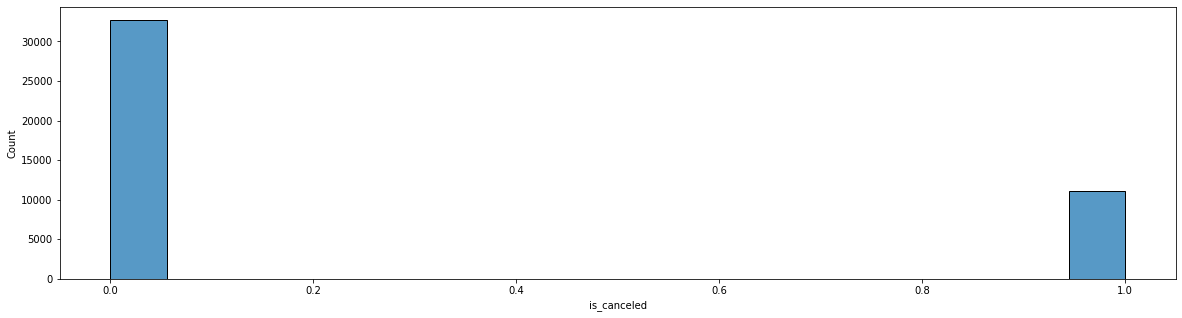

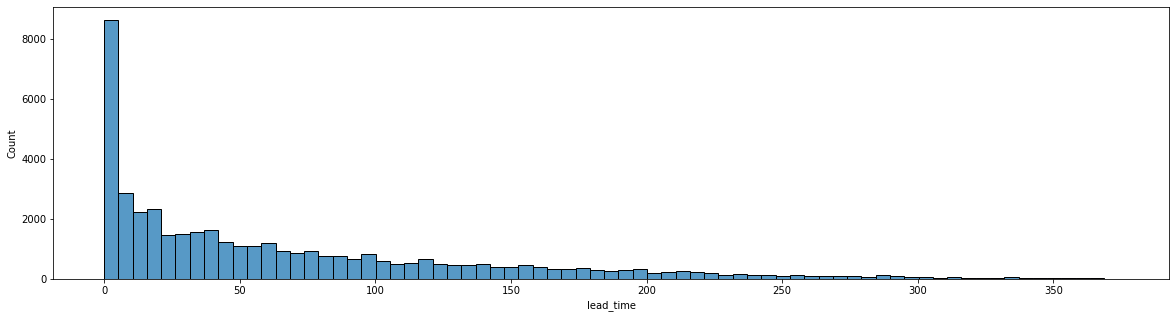

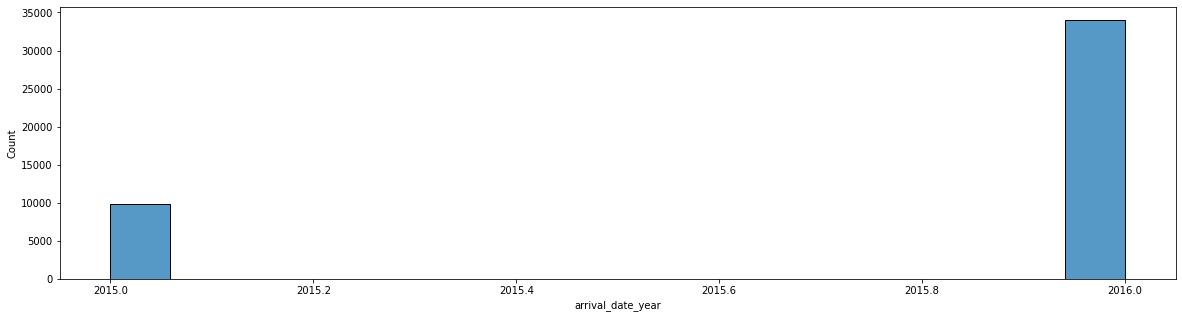

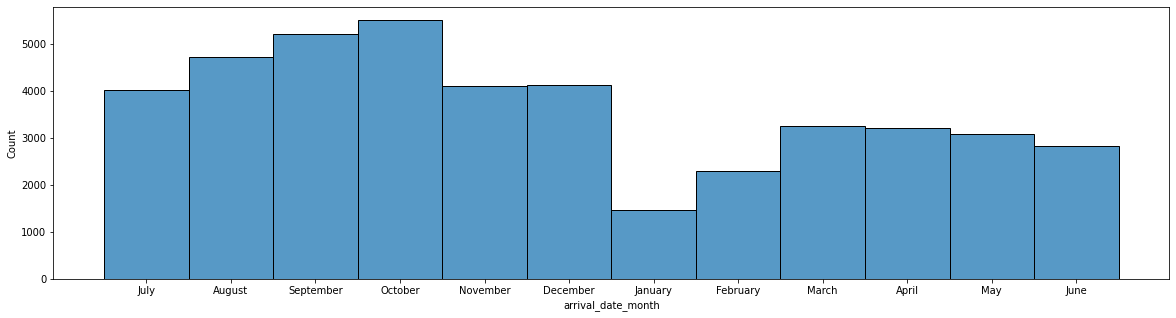

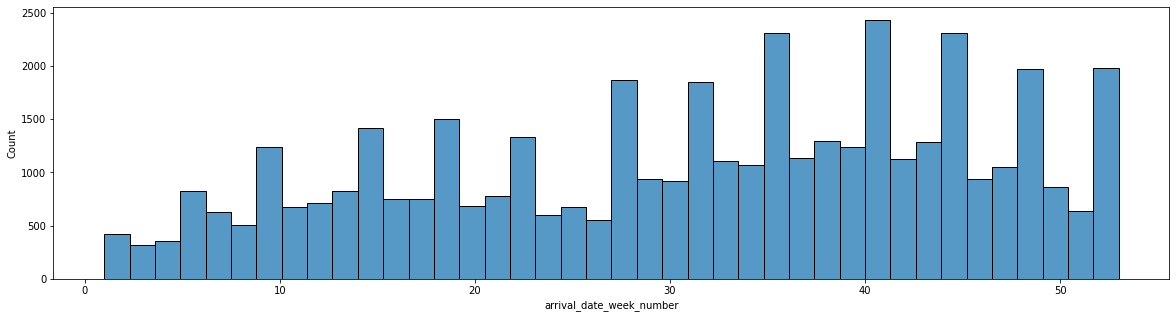

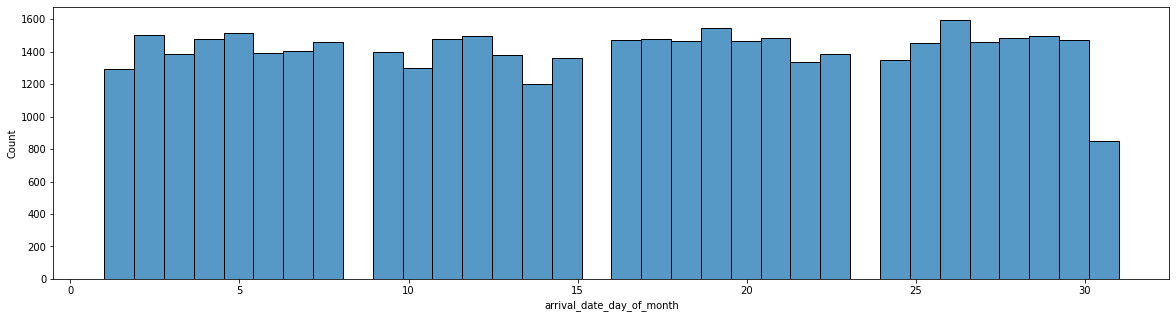

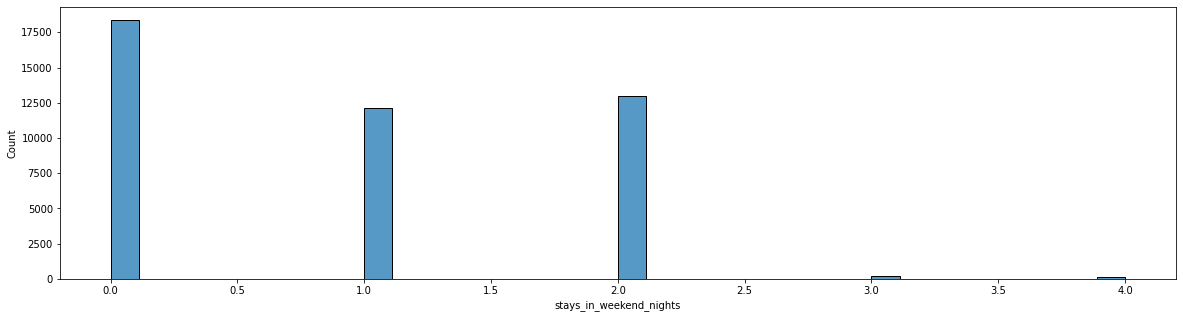

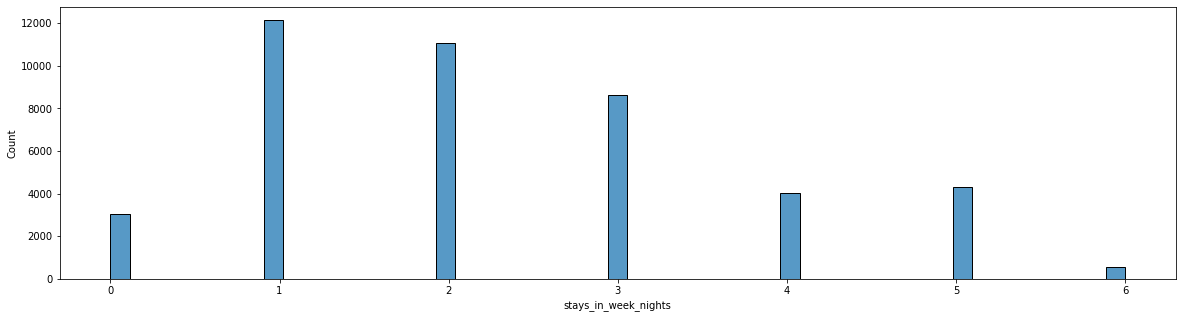

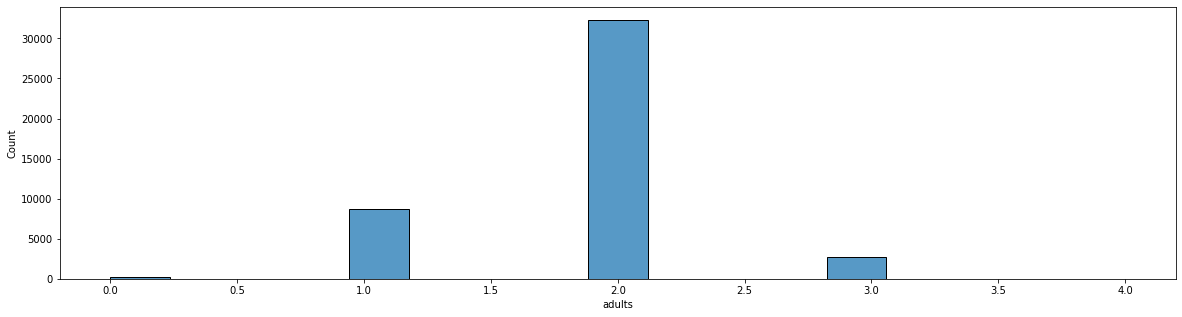

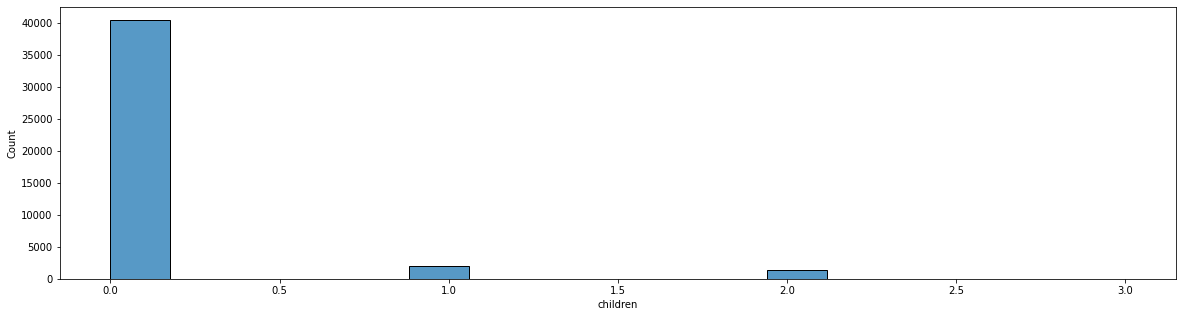

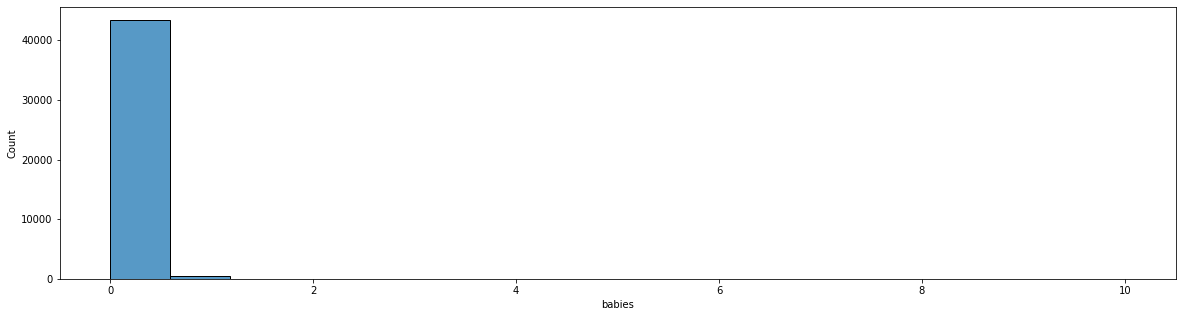

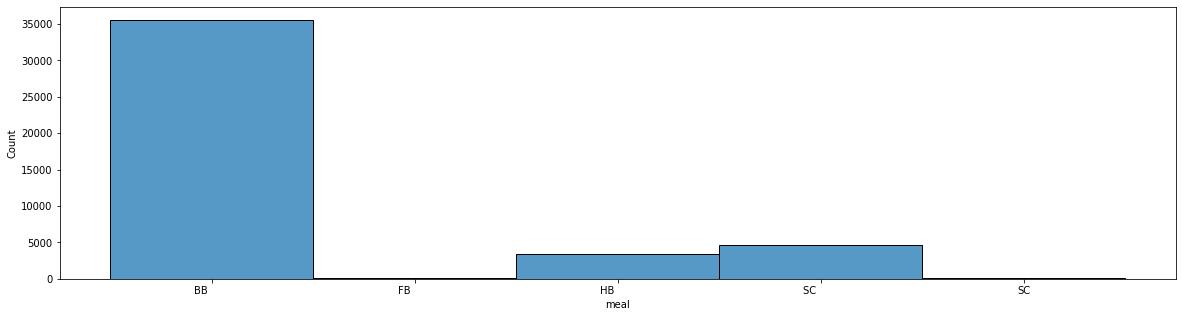

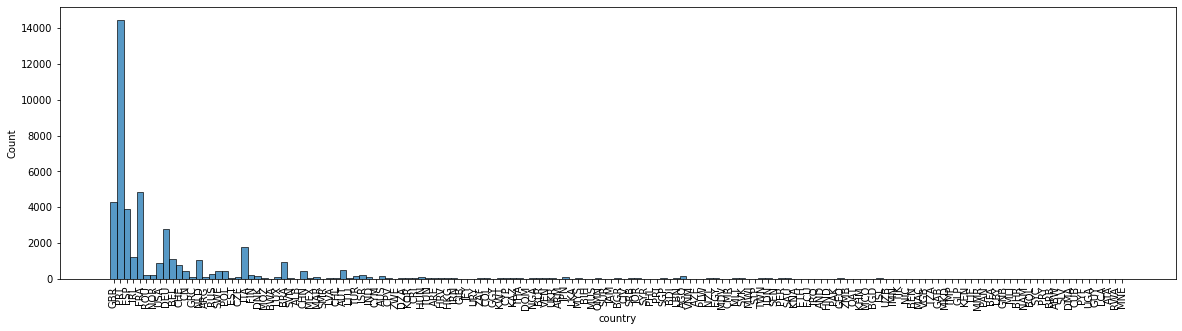

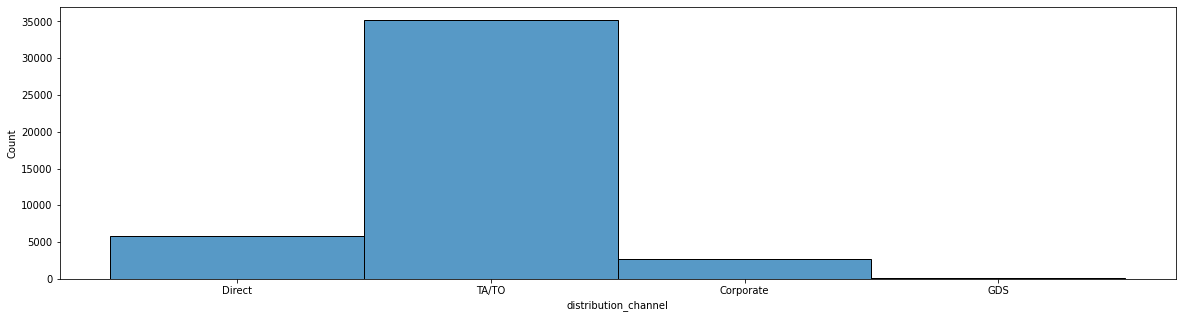

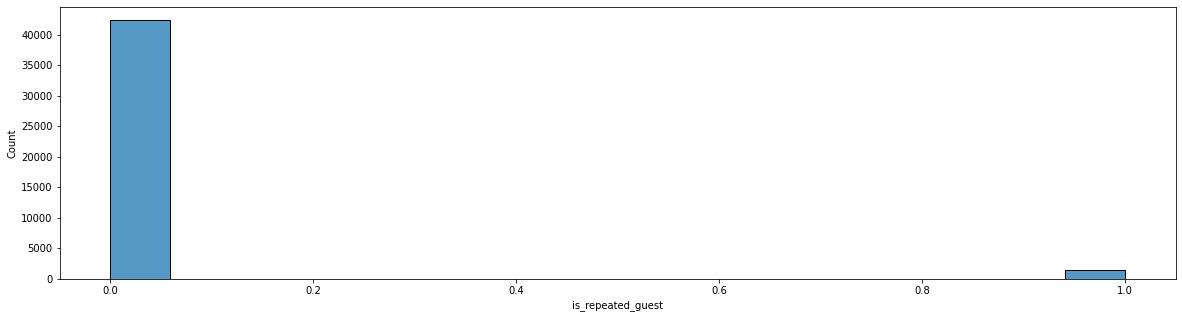

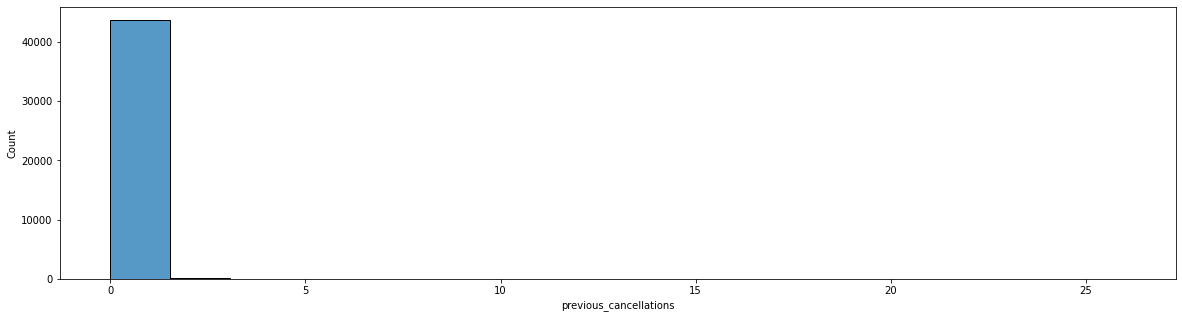

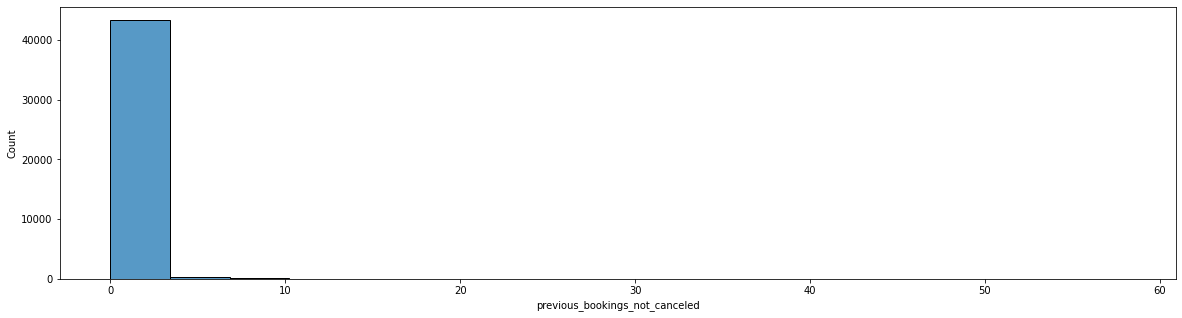

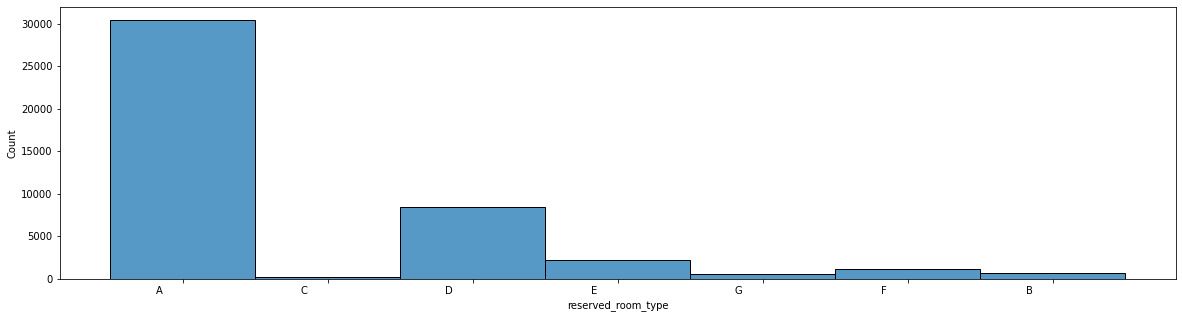

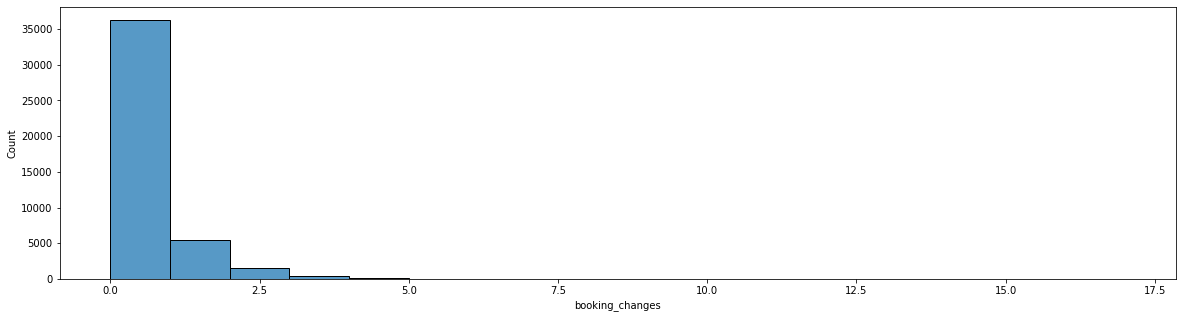

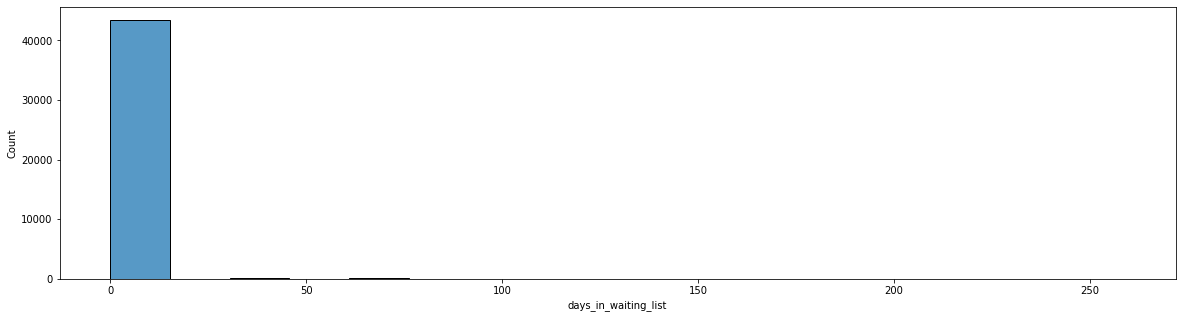

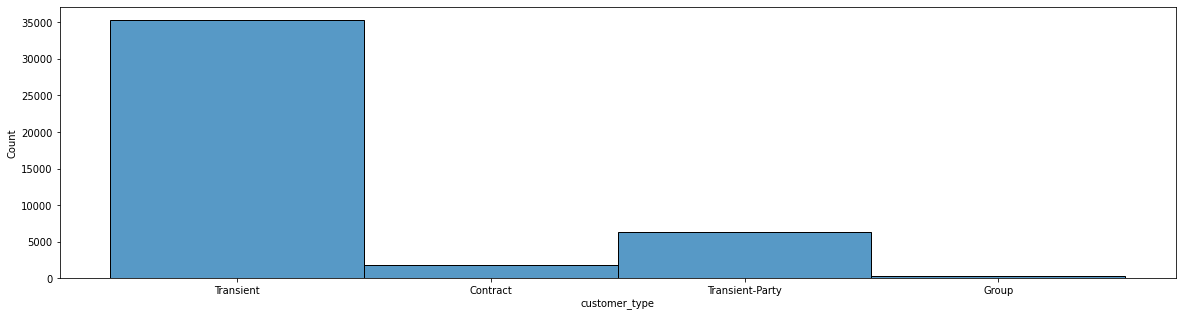

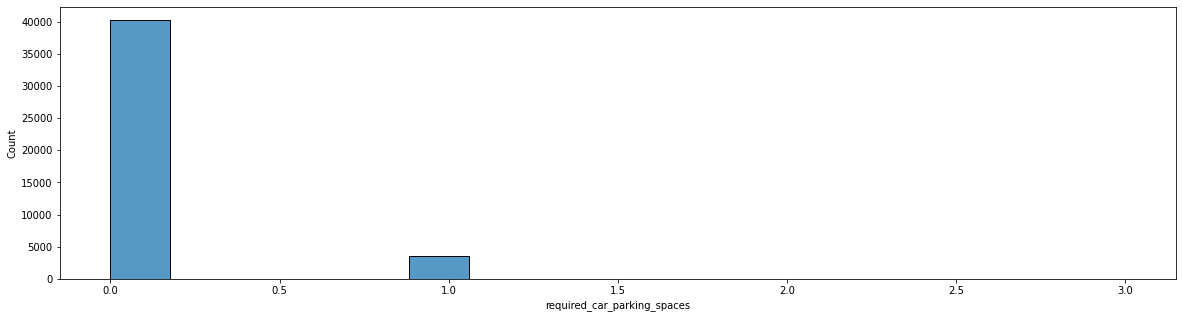

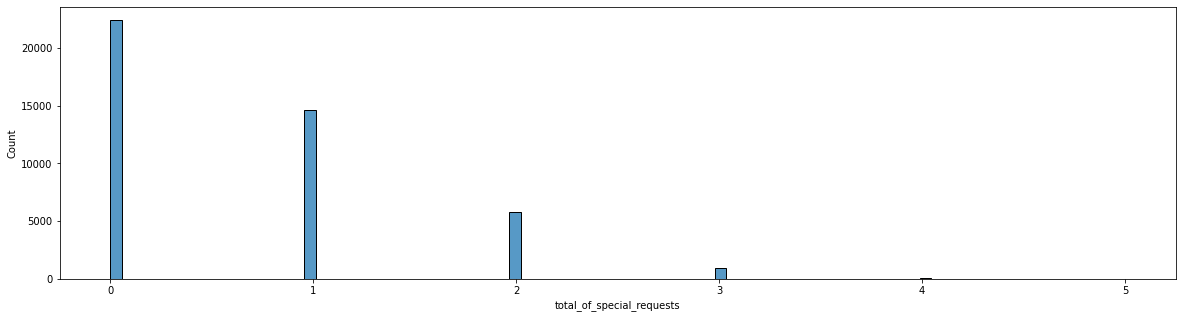

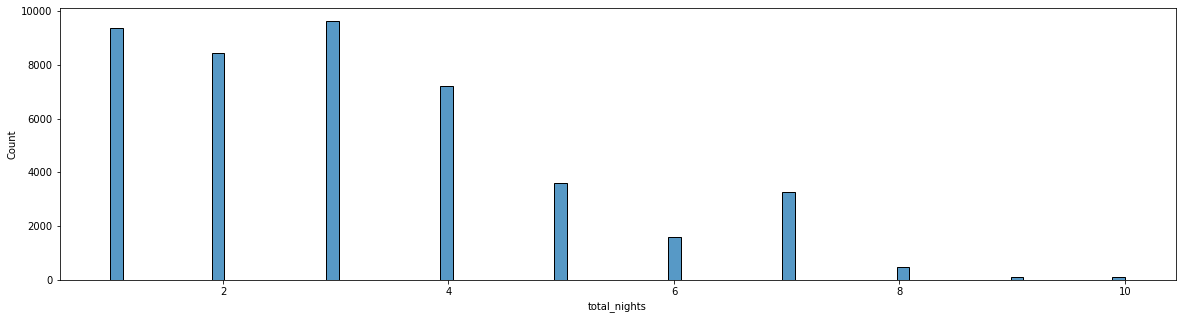

In [20]:
hist_my_data(df_train)

In [21]:
analyze_my_categorical_features(df_train)

Столбец arrival_date_month содержит следующие значения:
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

Столбец meal содержит следующие значения:
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']

Столбец country содержит следующие значения:
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 

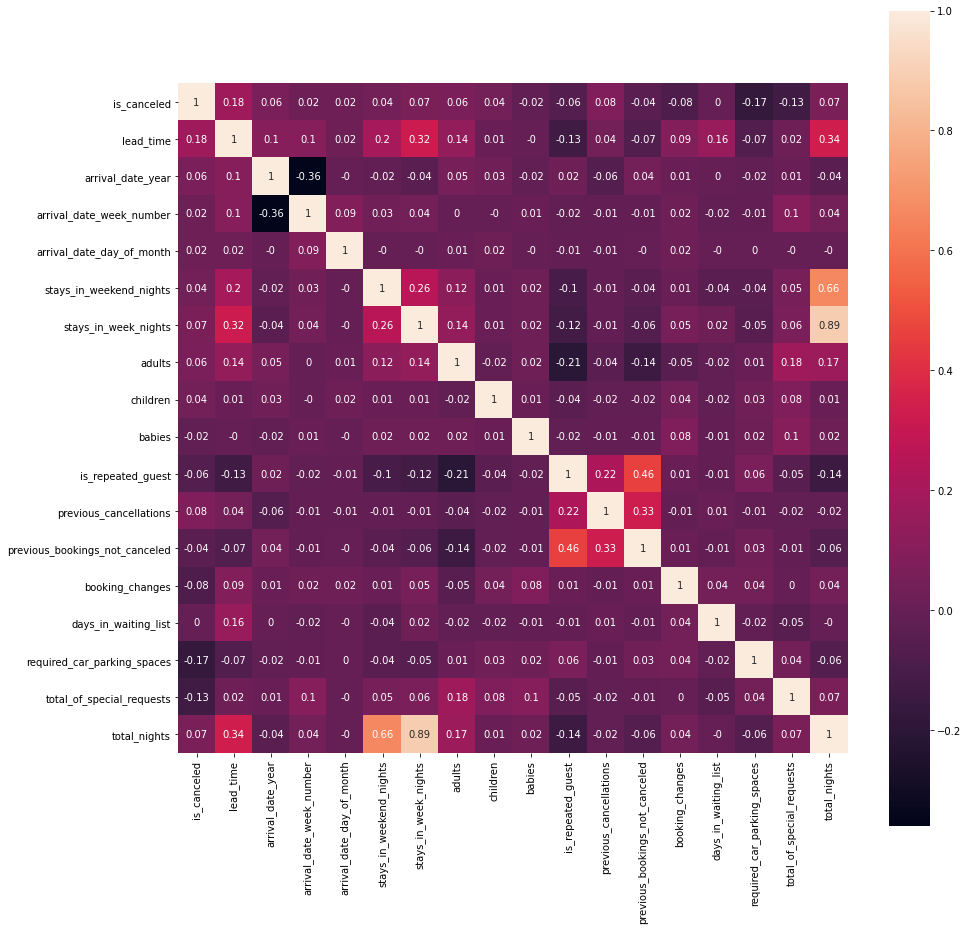

In [114]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr().round(2), annot=True, square=True);
plt.show()

Видно, что есть зависимость между общим количеством ночей и количеством ночей в будни и выходные дни, что вполне логично. Чтобы избавиться от коллениарности в данных в дальнейшем удалим столбец с общим количеством ночей.

##### Тестовая выборка

In [22]:
describe_my_data(df_test)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24695 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     24695 non-null  int64  
 1   lead_time                       24695 non-null  float64
 2   arrival_date_year               24695 non-null  int64  
 3   arrival_date_month              24695 non-null  object 
 4   arrival_date_week_number        24695 non-null  int64  
 5   arrival_date_day_of_month       24695 non-null  int64  
 6   stays_in_weekend_nights         24695 non-null  int64  
 7   stays_in_week_nights            24695 non-null  int64  
 8   adults                          24695 non-null  float64
 9   children                        24695 non-null  float64
 10  babies                          24695 non-null  float64
 11  meal                            24695 non-null  object 
 12  country      

In [116]:
values_in_my_data(df_test)

Столбец is_canceled содержит следующие значения:
1     7785
0    16910
Name: is_canceled, dtype: int64

Столбец lead_time содержит следующие значения:
367.0       1
354.0       1
366.0       1
361.0       2
349.0       2
         ... 
4.0       348
3.0       370
2.0       454
1.0       741
0.0      1292
Name: lead_time, Length: 368, dtype: int64

Столбец arrival_date_year содержит следующие значения:
2017    24695
Name: arrival_date_year, dtype: int64

Столбец arrival_date_month содержит следующие значения:
January     2368
August      2721
February    2768
March       3150
July        3188
June        3334
April       3426
May         3740
Name: arrival_date_month, dtype: int64

Столбец arrival_date_week_number содержит следующие значения:
35    423
2     499
3     510
5     541
4     554
34    567
32    578
6     590
1     610
12    635
31    655
29    659
30    661
33    691
10    716
16    717
14    724
9     731
13    734
27    742
23    744
11    747
8     755
7     758
24    762

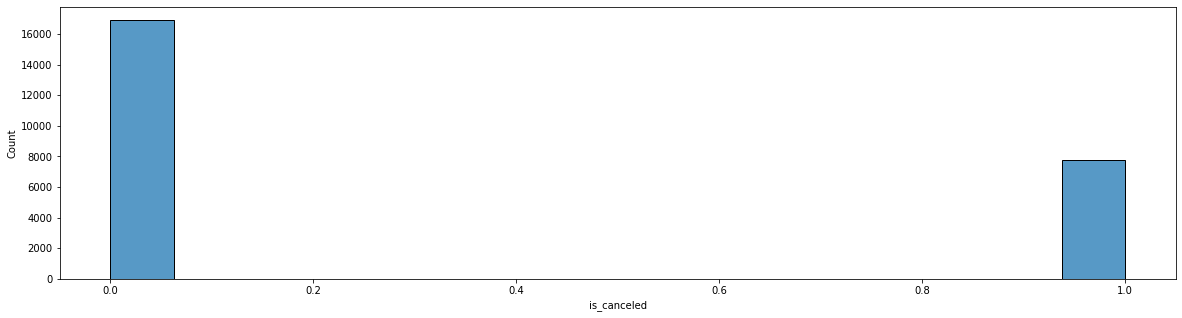

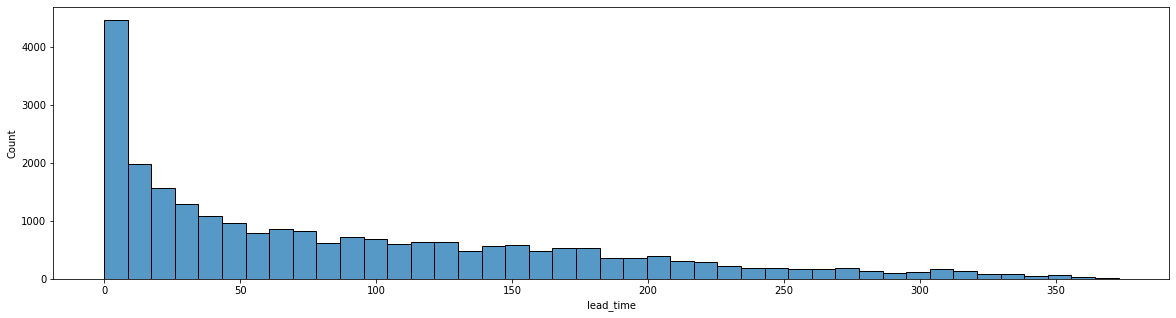

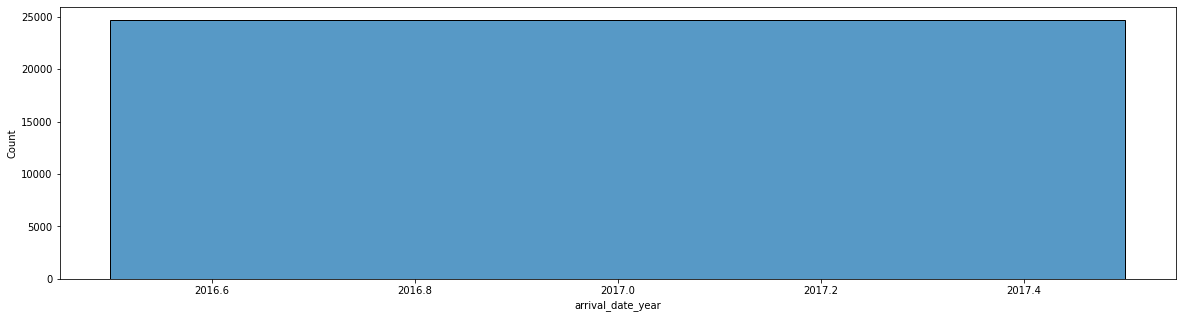

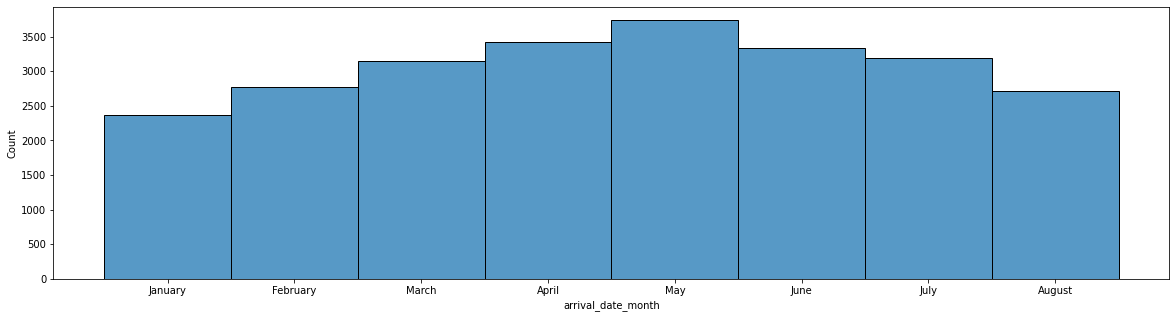

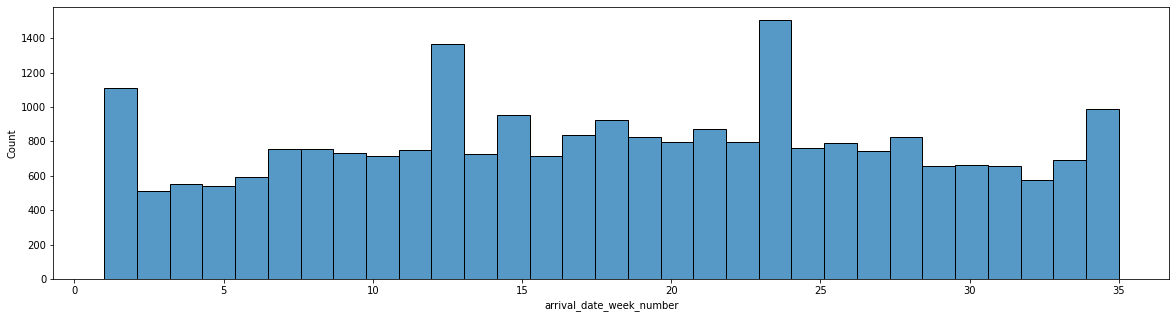

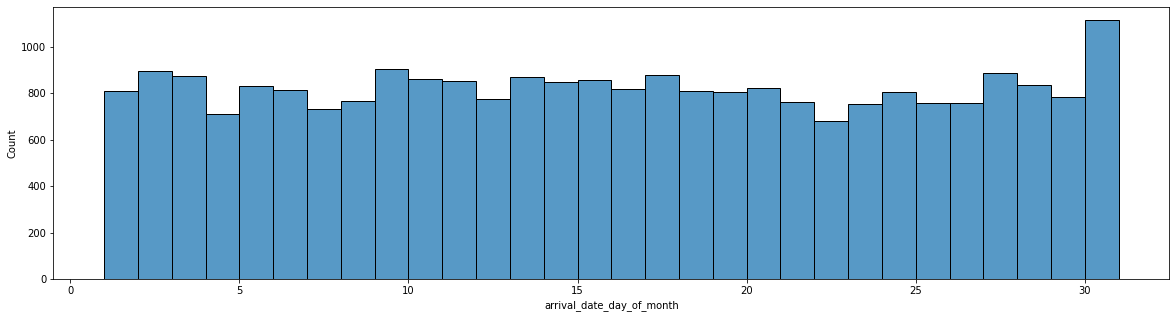

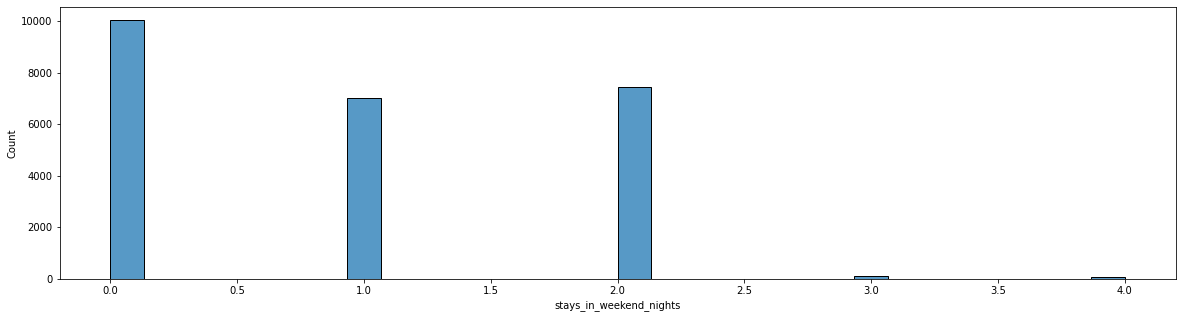

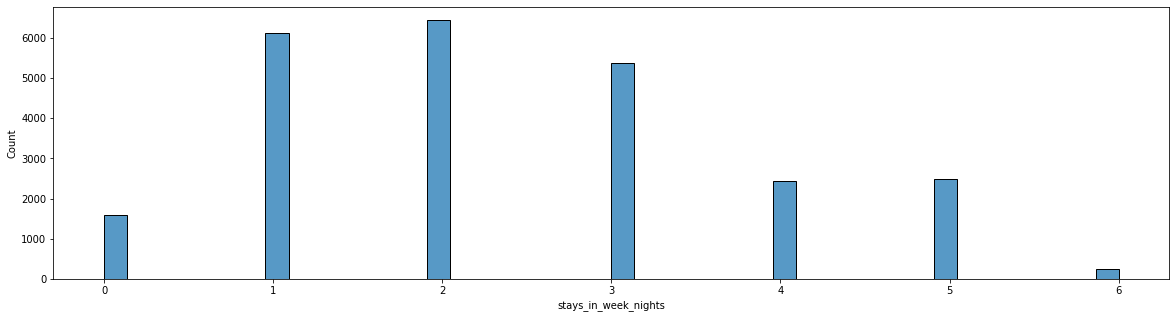

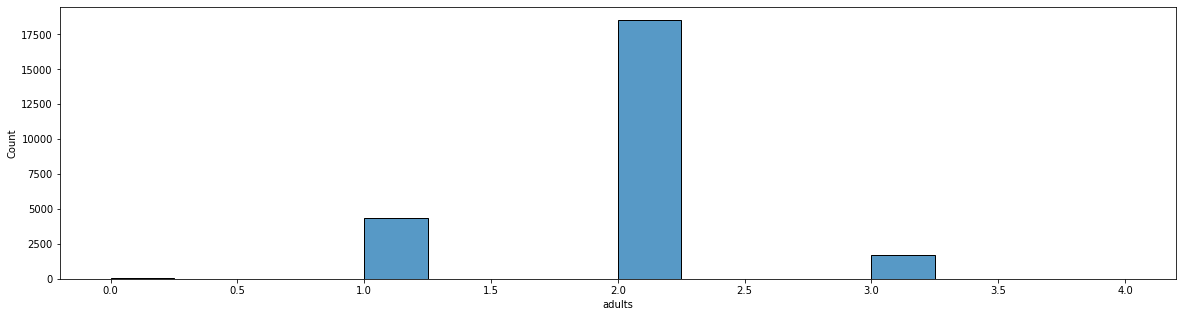

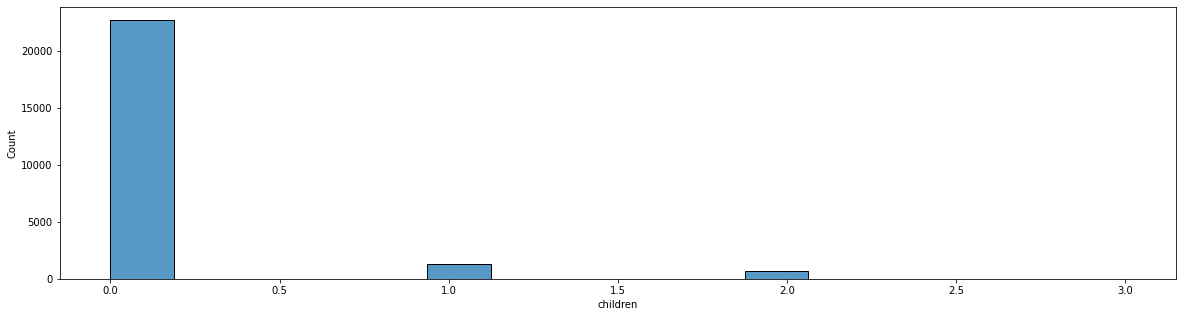

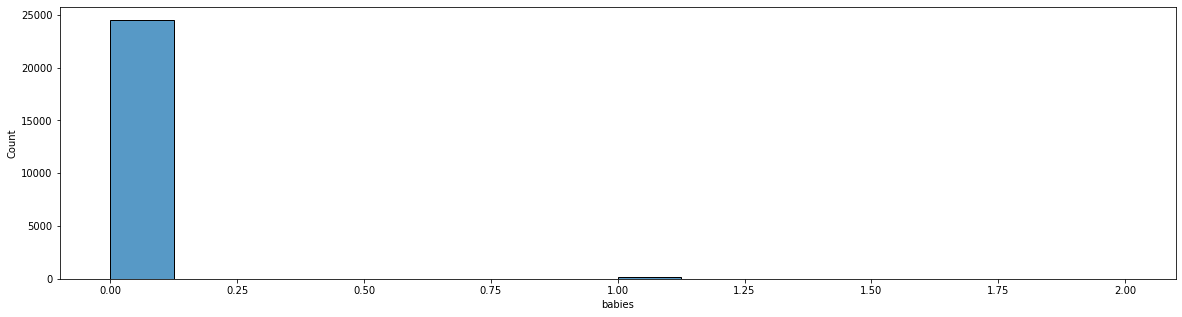

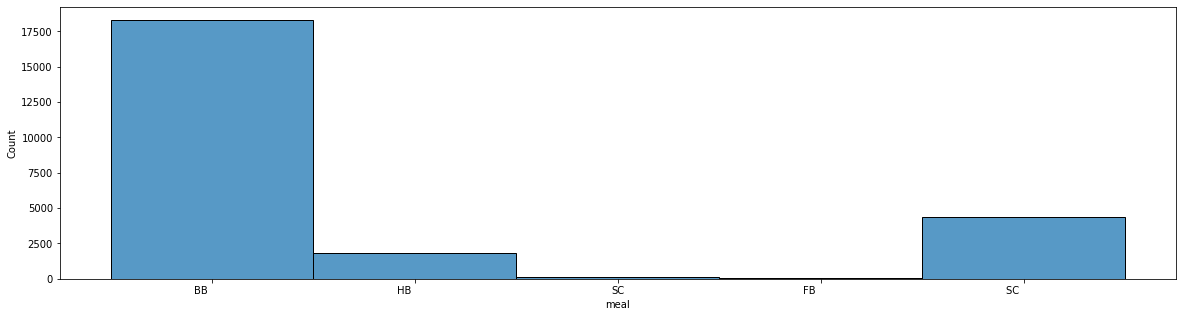

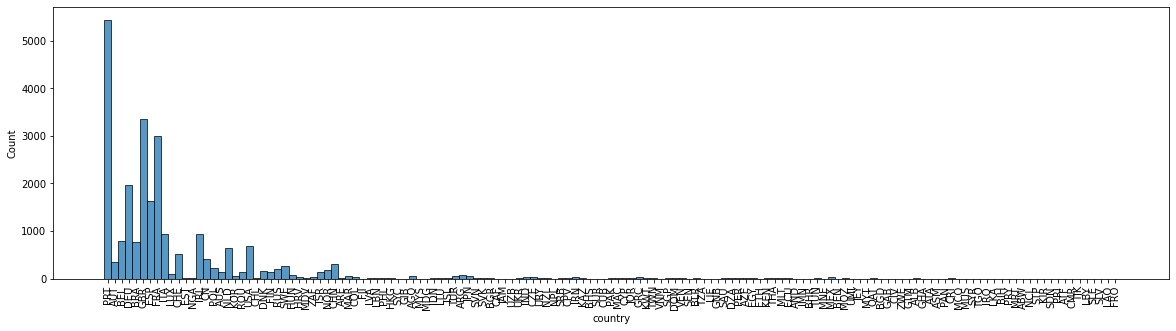

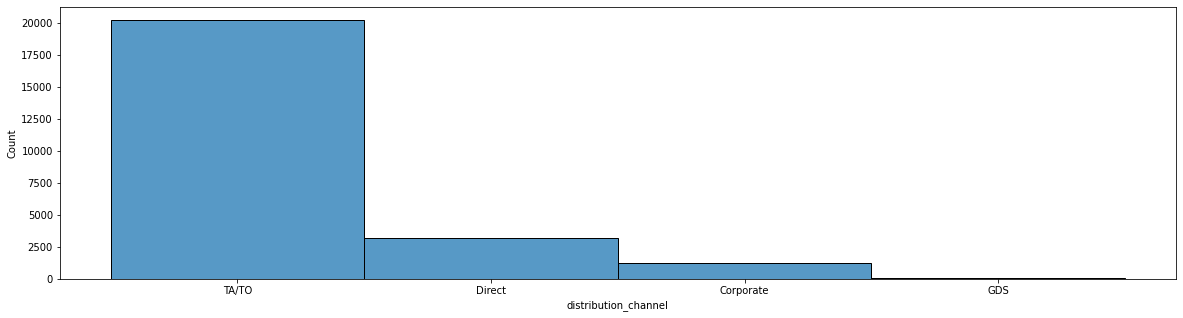

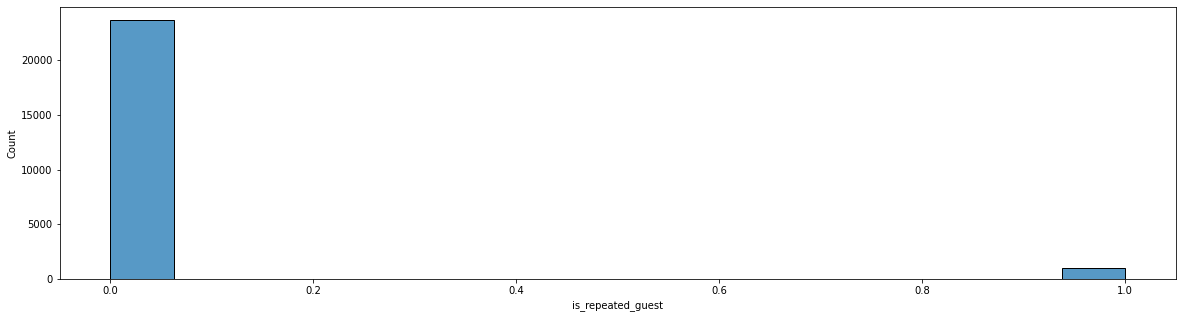

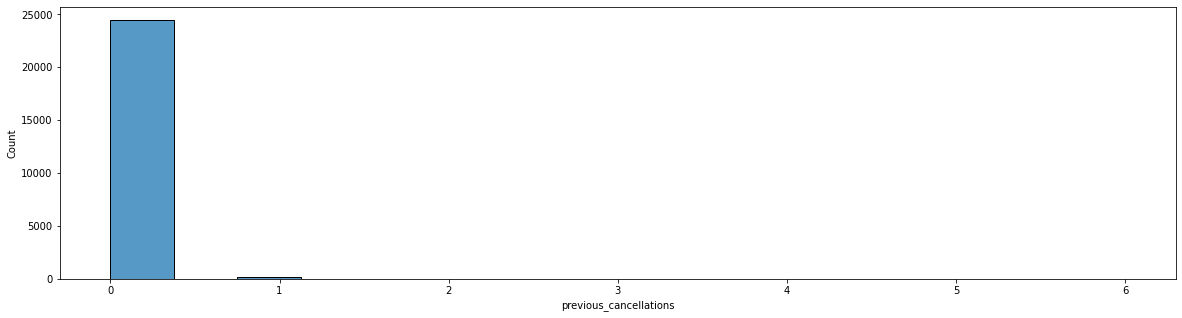

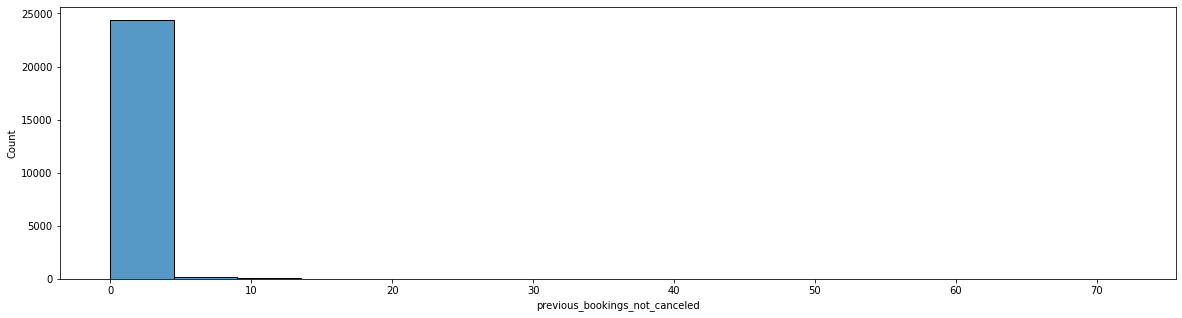

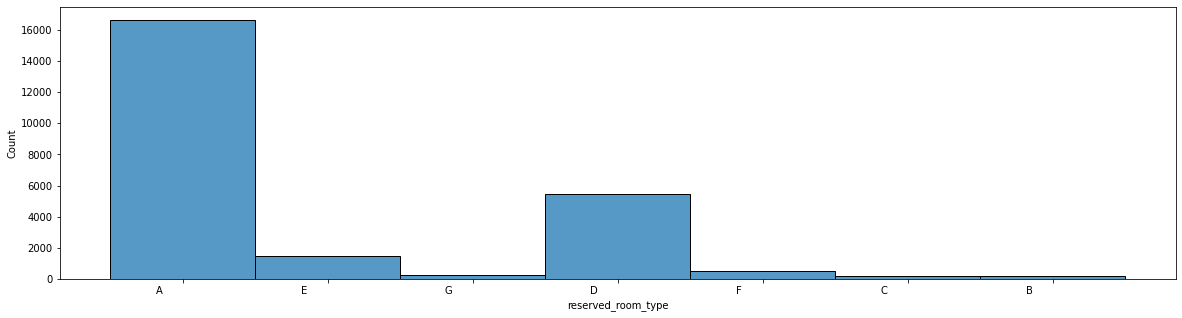

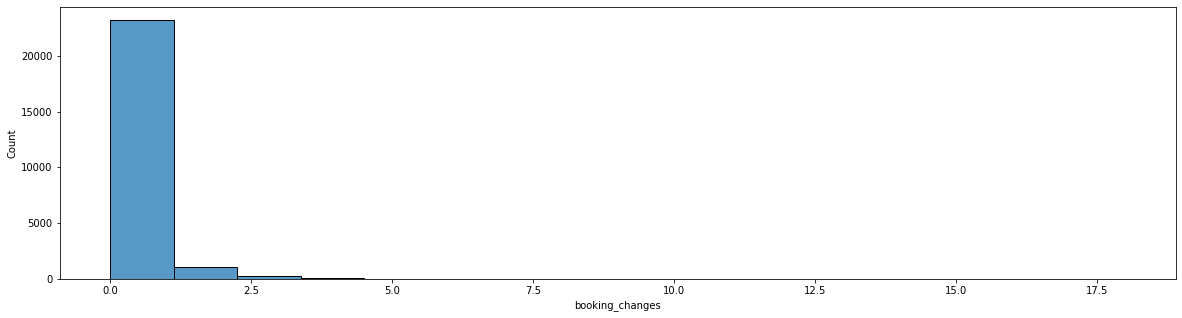

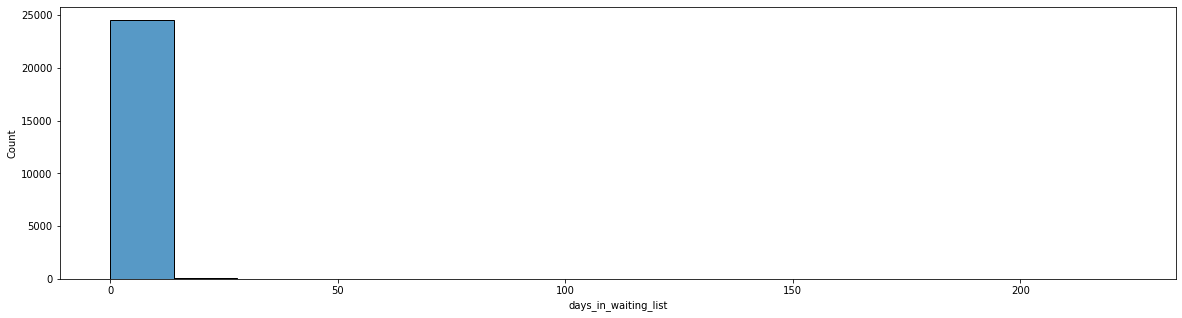

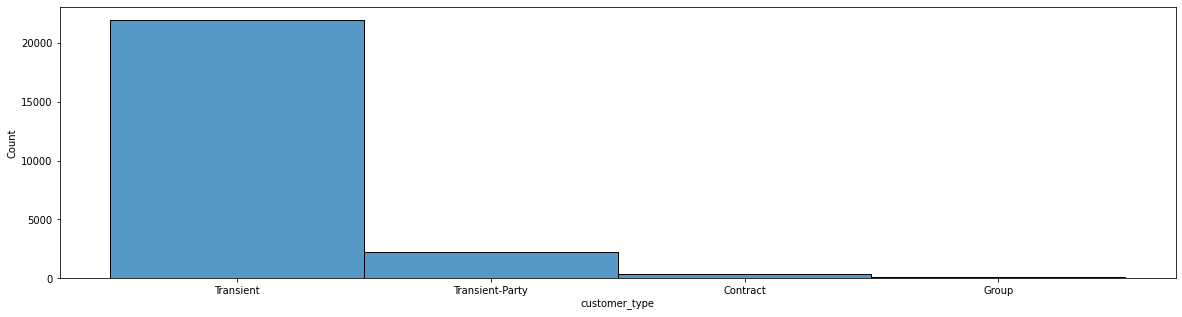

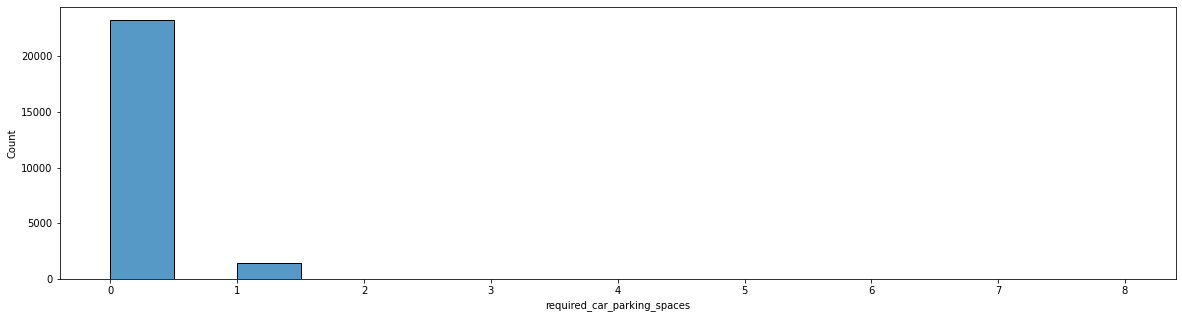

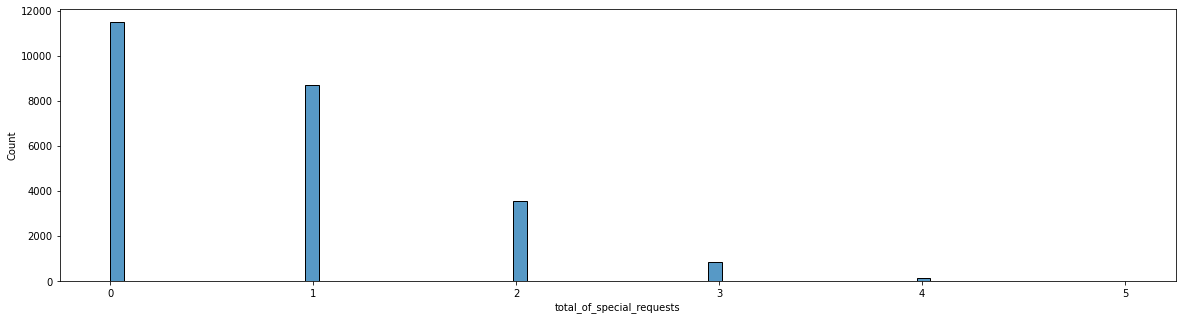

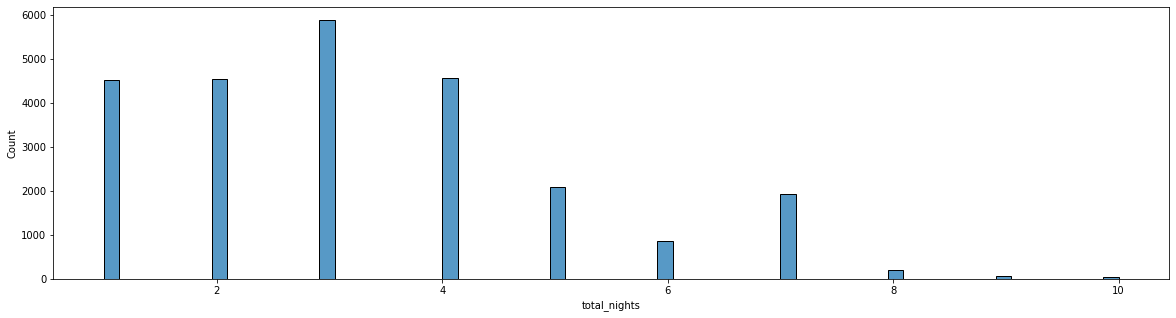

In [23]:
hist_my_data(df_test)

In [118]:
analyze_my_categorical_features(df_test)

Столбец arrival_date_month содержит следующие значения:
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

Столбец meal содержит следующие значения:
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']

Столбец country содержит следующие значения:
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'M

#### Предобработка

In [26]:
df_train = df_train[df_train.babies < 5]

In [27]:
df_test = df_test[df_test.required_car_parking_spaces < 3]

In [28]:
df_train = df_train[df_train.adults != 0]

In [29]:
df_test = df_test[df_test.adults != 0]

In [30]:
df_train['has_cancellations'] = df_train['previous_cancellations'] > 0
df_train['has_cancellations'] = df_train['has_cancellations'].astype('int')

df_train['has_successful_bookings'] = df_train['previous_bookings_not_canceled'] > 0
df_train['has_successful_bookings'] = df_train['previous_bookings_not_canceled'].astype('int')

df_train = df_train.drop(columns=['previous_cancellations', 'is_repeated_guest', 'previous_bookings_not_canceled'])

In [31]:
df_test['has_cancellations'] = df_test['previous_cancellations'] > 0
df_test['has_cancellations'] = df_test['has_cancellations'].astype('int')

df_test['has_successful_bookings'] = df_test['previous_bookings_not_canceled'] > 0
df_test['has_successful_bookings'] = df_test['previous_bookings_not_canceled'].astype('int')

df_test = df_test.drop(columns=['previous_cancellations', 'is_repeated_guest', 'previous_bookings_not_canceled'])

In [32]:
def delete_spaces(data):
    for column in data.select_dtypes('object').columns:
        data[column] = data[column].apply(lambda x: x.replace(' ', ''))

In [33]:
delete_spaces(df_train)
delete_spaces(df_test)

In [34]:
def float_to_int(data, columns):
    for column in columns:
        data[column] = data[column].astype('int')
    return data

In [35]:
df_train = float_to_int(data=df_train, columns=('adults', 'children', 'babies', 'lead_time'))
df_test = float_to_int(data=df_test, columns=('adults', 'children', 'babies', 'lead_time'))

In [36]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int')
ohe.fit(df_train.select_dtypes('object'))
def get_ohe(data, columns):
    temp_data = pd.DataFrame(data=ohe.transform(data[columns]), columns=ohe.get_feature_names())
    data = data.drop(columns=columns, axis=1)
    data = pd.concat([data.reset_index(drop=True), temp_data], axis=1)
    return data

In [37]:
df_train_ohe = get_ohe(df_train, df_train.select_dtypes('object').columns)
df_test_ohe = get_ohe(df_test, df_test.select_dtypes('object').columns)

In [38]:
df_train_ohe = df_train_ohe.drop(columns=['total_nights'])
df_test_ohe = df_test_ohe.drop(columns=['total_nights'])

**С обучающими и тестовыми данными все хорошо - пропусков и аномальних значений не наблюдается, с типами все впорядке, дубликаты отсутствуют.**

#### Формировка признаков и разбивка данных

In [39]:
features = df_train_ohe.drop(columns='is_canceled')
target = df_train_ohe['is_canceled']

In [40]:
target.value_counts(normalize=True)

0    0.745914
1    0.254086
Name: is_canceled, dtype: float64

Наблюдается скошенность данных в сторону нулевых значений.

In [134]:
features_test = df_test_ohe.drop(columns='is_canceled')
target_test = df_test_ohe['is_canceled']

Масштабируем:

In [135]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features))
features.columns = features.columns
features_test = pd.DataFrame(scaler.transform(features_test))
target_test = target_test.reset_index(drop=True)
features_test.columns = features.columns

### Формулировка ML-задачи на основе бизнес-задачи

In [136]:
BUDGET = 400000

DEPOSIT = 0.8

COEFFICIENT1 = 1.2 # весна и осень
COEFFICIENT2 = 1.4 # лето

PRICE_PER_NIGHT_A = 1000
PRICE_PER_NIGHT_B = 800
PRICE_PER_NIGHT_C = 600
PRICE_PER_NIGHT_D = 550
PRICE_PER_NIGHT_E = 500
PRICE_PER_NIGHT_F = 450
PRICE_PER_NIGHT_G = 350

SERVICE_A = 400
SERVICE_B = 350
SERVICE_C = 350
SERVICE_D = 150
SERVICE_E = 150
SERVICE_F = 150
SERVICE_G = 150

Объявим функцию для нахождения прибыли без введения депозитов

In [137]:
def find_profit(data):

    coef = 1
    if data.arrival_date_month in('March', 'April', 'May', 'September', 'October', 'November'):
        coef = COEFFICIENT1
    if data.arrival_date_month in('June', 'July', 'August'):
        coef = COEFFICIENT2
    
    if data.is_canceled:
        if data.reserved_room_type == 'A':
            profit = -(PRICE_PER_NIGHT_A * coef + SERVICE_A)
        if data.reserved_room_type == 'B':
            profit = -(PRICE_PER_NIGHT_B * coef + SERVICE_B)
        if data.reserved_room_type == 'C':
            profit = -(PRICE_PER_NIGHT_C * coef + SERVICE_C)
        if data.reserved_room_type == 'D':
            profit = -(PRICE_PER_NIGHT_D * coef + SERVICE_D)
        if data.reserved_room_type == 'E':
            profit = -(PRICE_PER_NIGHT_E * coef + SERVICE_E)
        if data.reserved_room_type == 'F':
            profit = -(PRICE_PER_NIGHT_F * coef + SERVICE_F)
        if data.reserved_room_type == 'G':
            profit = -(PRICE_PER_NIGHT_G * coef + SERVICE_G)
    else:
        if data.reserved_room_type == 'A':
            profit = data.total_nights * PRICE_PER_NIGHT_A * coef - SERVICE_A - int(data.total_nights / 2) * SERVICE_A
        if data.reserved_room_type == 'B':
            profit = data.total_nights * PRICE_PER_NIGHT_B * coef - SERVICE_B - int(data.total_nights / 2) * SERVICE_B
        if data.reserved_room_type == 'C':
            profit = data.total_nights * PRICE_PER_NIGHT_C * coef - SERVICE_C - int(data.total_nights / 2) * SERVICE_C
        if data.reserved_room_type == 'D':
            profit = data.total_nights * PRICE_PER_NIGHT_D * coef - SERVICE_D - int(data.total_nights / 2) * SERVICE_D
        if data.reserved_room_type == 'E':
            profit = data.total_nights * PRICE_PER_NIGHT_E * coef - SERVICE_E - int(data.total_nights / 2) * SERVICE_E
        if data.reserved_room_type == 'F':
            profit = data.total_nights * PRICE_PER_NIGHT_F * coef - SERVICE_F - int(data.total_nights / 2) * SERVICE_F
        if data.reserved_room_type == 'G':
            profit = data.total_nights * PRICE_PER_NIGHT_G * coef - SERVICE_G - int(data.total_nights / 2) * SERVICE_G
            
    return profit

In [138]:
data_for_analyze = df_test.copy(False)
data_for_analyze['profit'] = df_test.apply(find_profit, axis=1)
print(f'Выручка составит {data_for_analyze.profit.sum() /1e6 :.4} млн.')

Выручка составит 32.6 млн.


Без внедрения депозитов выручка составит 32.6 млн.

### Разработка модели ML и нахождение предсказанной прибыли

В качестве метрики выберем полноту, так как при ошибке нераспознания положительного класса мы теряем прибыль и поэтому мы хотим максимизировать долю правильно найденных положительных объектов среди всех объектов положительного класса.

#### Разработка модели

Объявим функцию для кросс-валидации.

In [41]:
def my_cross_validation(model, features=features, target=target, cv=3 , sampling='normal', scoring='recall'):
    '''
    Функция для кросс-валидации с возможностью повышения и понижения выборки.
    '''
    scores = []
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    for train_index, valid_index in cv.split(features, target):
        features_train, target_train = features.iloc[train_index], target[train_index]
        features_valid, target_valid = features.iloc[valid_index], target[valid_index]
        
        if sampling == 'downsample':
            multiplier = sum(target_train == 1) / sum(target_train == 0)
            if multiplier < 1:
                (features_train, target_train) = shuffle(
                                    pd.concat([features_train[target_train == 0].sample(frac=multiplier, random_state=0)] + [features_train[target_train == 1]]),
                                    pd.concat([target_train[target_train == 0].sample(frac=multiplier, random_state=0)] + [target_train[target_train == 1]]),
                                    random_state=0)
            elif multiplier > 1:
                multiplier = sum(target_train == 0) / sum(target_train == 1)
                (features_train, target_train) = shuffle(
                                    pd.concat([features_train[target_train == 1].sample(frac=multiplier, random_state=0)] + [features_train[target_train == 0]]),
                                    pd.concat([target_train[target_train == 1].sample(frac=multiplier, random_state=0)] + [target_train[target_train == 0]]),
                                    random_state=0)
            else:
                pass
                
        if sampling == 'upsample':
            multiplier = round(sum(target_train == 0) / sum(target_train == 1))
            if multiplier > 1:
                features_train, target_train = shuffle(
                                    pd.concat([features_train[target_train == 0]] + [features_train[target_train == 1]]*multiplier),
                                    pd.concat([target_train[target_train == 0]] + [target_train[target_train == 1]]*multiplier),
                                    random_state=0)
            elif multiplier < 1:
                multiplier = round(sum(target_train == 1) / sum(target_train == 0))
                features_train, target_train = shuffle(
                                    pd.concat([features_train[target_train == 1]] + [features_train[target_train == 0]]*multiplier),
                                    pd.concat([target_train[target_train == 1]] + [target_train[target_train == 0]]*multiplier),
                                    random_state=0)
            else:
                pass
            
        model = model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
    
        if scoring == 'f1':
            score = f1_score(target_valid, predictions)
            
        if scoring == 'recall':
            score = recall_score(target_valid, predictions)
            
        if scoring == 'precision':
            score = precision_score(target_valid, predictions)
        
        scores.append(score)
    #print(scores)   
    return model, np.mean(scores)

Объявим функцию для нахождения лучших значений гиперпараметров различных моделей. Она возвращает выбранную модель с лучшими гиперпараметрами.

In [140]:
def find_best_model_with_valid(model, features=features, target=target,
                    max_depth=100, n_estimators=10,  max_iter=100, step=5, solver='liblinear',
                    cv=3, scoring='recall', sampling='normal', class_weight=None):
    '''
    Функция для нахождения путем grid-search лучших гиперпараметров заданной модели.
    '''
    if model == 'tree':
        score_best = 0
        for depth in range(1, max_depth, step):
            dt = DecisionTreeClassifier(random_state=0, max_depth=depth, class_weight=class_weight)
            model, score = my_cross_validation(dt, features=features, target=target, cv=cv , sampling=sampling, scoring='f1')
            #print(model, score)
            if score > score_best:
                best_tree_model = model
                score_best = score
        print(f'{scoring} лучшей модели {score_best:.3}')
        return best_tree_model.fit(features, target)

    if model == 'forest':
        score_best  = 0
        for estimator in range(1, n_estimators, step):
            for depth in range(1, max_depth, step):
                rf = RandomForestClassifier(random_state=0, n_estimators=estimator, max_depth=depth, class_weight=class_weight)
                model, score = my_cross_validation(rf, features=features, target=target, cv=cv , sampling=sampling, scoring='f1')
                if score > score_best:
                    best_forest_model = model
                    score_best = score
        print(f'{scoring} лучшей модели {score_best:.3}')
        return best_forest_model.fit(features, target)
    
    if model == 'logistic':
        score_best  = 0
        for iterations in range(50, max_iter, step):
            reg = LogisticRegression(random_state=0, solver=solver, max_iter=iterations, class_weight=class_weight)
            model, score = my_cross_validation(reg, features=features, target=target, cv=cv , sampling=sampling, scoring='f1')
            if score > score_best:
                best_regression_model = model
                score_best = score
        print(f'{scoring} лучшей модели {score_best:.3}')
        return best_regression_model.fit(features, target)

##### Дерево решений

In [141]:
best_tree = find_best_model_with_valid('tree', max_depth=200, step=10)

recall лучшей модели 0.574


In [142]:
best_tree_upsampled = find_best_model_with_valid('tree', sampling='upsample', max_depth=200, step=10)

recall лучшей модели 0.612


In [143]:
best_tree_downsampled = find_best_model_with_valid('tree', sampling='downsample', max_depth=200, step=10)

recall лучшей модели 0.607


In [144]:
best_tree_balanced = find_best_model_with_valid('tree', class_weight='balanced', max_depth=200, step=10)

recall лучшей модели 0.612


##### Случайный лес

In [145]:
best_forest = find_best_model_with_valid('forest')

recall лучшей модели 0.559


In [146]:
best_forest_upsampled = find_best_model_with_valid('forest', sampling='upsample')

recall лучшей модели 0.627


In [147]:
best_forest_downsampled = find_best_model_with_valid('forest', sampling='downsample')

recall лучшей модели 0.607


In [148]:
best_forest_balanced = find_best_model_with_valid('forest', class_weight='balanced')

recall лучшей модели 0.621


##### Логистическая регрессия

In [149]:
best_log_regression = find_best_model_with_valid('logistic')

recall лучшей модели 0.482


In [150]:
best_log_regression_upsampled = find_best_model_with_valid('logistic', sampling='upsample')

recall лучшей модели 0.573


In [151]:
best_log_regression_downsampled = find_best_model_with_valid('logistic', sampling='downsample')

recall лучшей модели 0.573


In [152]:
best_log_regression_balanced = find_best_model_with_valid('logistic', class_weight='balanced')

recall лучшей модели 0.574


В качестве лушей модели выберем на модель случайного леса, которая кросс-валидировалась на увеличенной выборке и имеет следующие параметры:
 - максимальная глубина 56;
 - количество деревьев 6.

#### Проверка модели на тестовых данных

In [43]:
recall_score(target_test, best_forest_upsampled.predict(features_test)).round(2)

0.51

#### Нахождение прибыли после введения депозитов

In [154]:
def predict_profit(data):
    
    coef = 1
    if data.arrival_date_month in('March', 'April', 'May', 'September', 'October', 'November'):
        coef = COEFFICIENT1
    if data.arrival_date_month in('June', 'July', 'August'):
        coef = COEFFICIENT2 
        
    if data.is_canceled and not(data.predicted_is_canceled):
        if data.reserved_room_type == 'A':
            profit = -(PRICE_PER_NIGHT_A * coef + SERVICE_A)
        if data.reserved_room_type == 'B':
            profit = -(PRICE_PER_NIGHT_B * coef + SERVICE_B)
        if data.reserved_room_type == 'C':
            profit = -(PRICE_PER_NIGHT_C * coef + SERVICE_C)
        if data.reserved_room_type == 'D':
            profit = -(PRICE_PER_NIGHT_D * coef + SERVICE_D)
        if data.reserved_room_type == 'E':
            profit = -(PRICE_PER_NIGHT_E * coef + SERVICE_E)
        if data.reserved_room_type == 'F':
            profit = -(PRICE_PER_NIGHT_F * coef + SERVICE_F)
        if data.reserved_room_type == 'G':
            profit = -(PRICE_PER_NIGHT_G * coef + SERVICE_G)        
        
    elif data.is_canceled and data.predicted_is_canceled:
        if data.reserved_room_type == 'A':
            profit = (PRICE_PER_NIGHT_A * coef + SERVICE_A) * DEPOSIT - (PRICE_PER_NIGHT_A * coef + SERVICE_A)
        if data.reserved_room_type == 'B':
            profit = (PRICE_PER_NIGHT_B * coef + SERVICE_B) * DEPOSIT - (PRICE_PER_NIGHT_B * coef + SERVICE_B)
        if data.reserved_room_type == 'C':
            profit = (PRICE_PER_NIGHT_C * coef + SERVICE_C) * DEPOSIT - (PRICE_PER_NIGHT_C * coef + SERVICE_C)
        if data.reserved_room_type == 'D':
            profit = (PRICE_PER_NIGHT_D * coef + SERVICE_D) * DEPOSIT - (PRICE_PER_NIGHT_D * coef + SERVICE_D)
        if data.reserved_room_type == 'E':
            profit = (PRICE_PER_NIGHT_E * coef + SERVICE_E) * DEPOSIT - (PRICE_PER_NIGHT_E * coef + SERVICE_E)
        if data.reserved_room_type == 'F':
            profit = (PRICE_PER_NIGHT_F * coef + SERVICE_F) * DEPOSIT - (PRICE_PER_NIGHT_F * coef + SERVICE_F)
        if data.reserved_room_type == 'G':
            profit = (PRICE_PER_NIGHT_G * coef + SERVICE_G) * DEPOSIT - (PRICE_PER_NIGHT_G * coef + SERVICE_G)
            
    else:
        if data.reserved_room_type == 'A':
            profit = data.total_nights * PRICE_PER_NIGHT_A * coef - SERVICE_A - int(data.total_nights / 2) * SERVICE_A
        if data.reserved_room_type == 'B':
            profit = data.total_nights * PRICE_PER_NIGHT_B * coef - SERVICE_B - int(data.total_nights / 2) * SERVICE_B
        if data.reserved_room_type == 'C':
            profit = data.total_nights * PRICE_PER_NIGHT_C * coef - SERVICE_C - int(data.total_nights / 2) * SERVICE_C
        if data.reserved_room_type == 'D':
            profit = data.total_nights * PRICE_PER_NIGHT_D * coef - SERVICE_D - int(data.total_nights / 2) * SERVICE_D
        if data.reserved_room_type == 'E':
            profit = data.total_nights * PRICE_PER_NIGHT_E * coef - SERVICE_E - int(data.total_nights / 2) * SERVICE_E
        if data.reserved_room_type == 'F':
            profit = data.total_nights * PRICE_PER_NIGHT_F * coef - SERVICE_F - int(data.total_nights / 2) * SERVICE_F
        if data.reserved_room_type == 'G':
            profit = data.total_nights * PRICE_PER_NIGHT_G * coef - SERVICE_G - int(data.total_nights / 2) * SERVICE_G
            
    return profit    

In [155]:
data_for_analyze['predicted_is_canceled'] = best_forest_upsampled.predict(features_test)
data_for_analyze['predicted_profit'] = data_for_analyze.apply(predict_profit, axis=1)

In [156]:
data_for_analyze[['is_canceled', 'predicted_is_canceled', 'profit', 'predicted_profit']].sample(5)

is_canceled  predicted_is_canceled  profit  predicted_profit
27151            0                      0  3600.0            3600.0
9295             1                      0  -700.0            -700.0
7280             0                      0  1000.0            1000.0
17408            1                      0  -920.0            -920.0
3695             0                      0  2800.0            2800.0

In [157]:
print(f'Выручка без депозитов составит {data_for_analyze.profit.sum() /1e6 :.4} млн.')

Выручка без депозитов составит 32.6 млн.


In [158]:
print(f'Выручка c депозитами составит {data_for_analyze.predicted_profit.sum() /1e6 :.4} млн.')

Выручка c депозитами составит 35.12 млн.


In [159]:
print(f'Разница в выручке после внедрения депозитов составит {(data_for_analyze.predicted_profit.sum() - data_for_analyze.profit.sum())/1e6 :.5} млн.')

Разница в выручке после внедрения депозитов составит 2.5207 млн.


### Найдем портрет «ненадёжного» клиента

In [160]:
df1 = pd.concat([df_train, df_test])
df1 = df1[df1.is_canceled == 1]

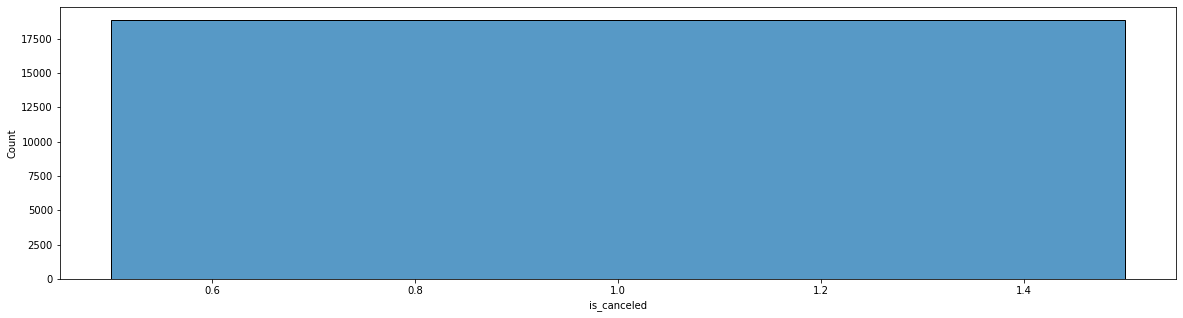

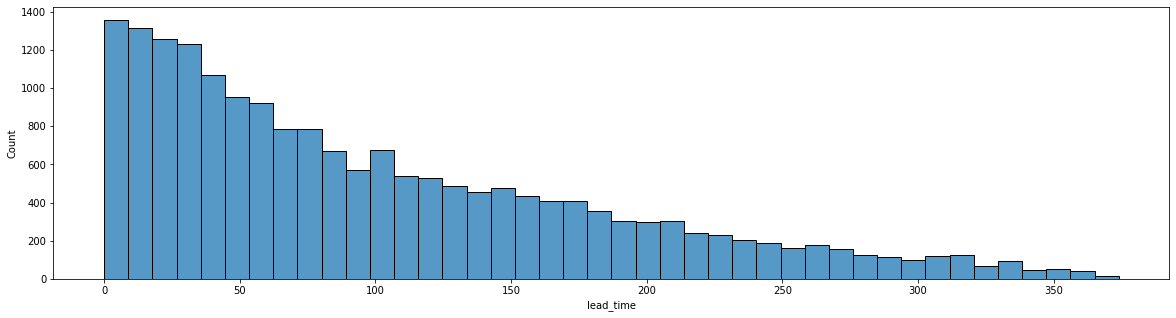

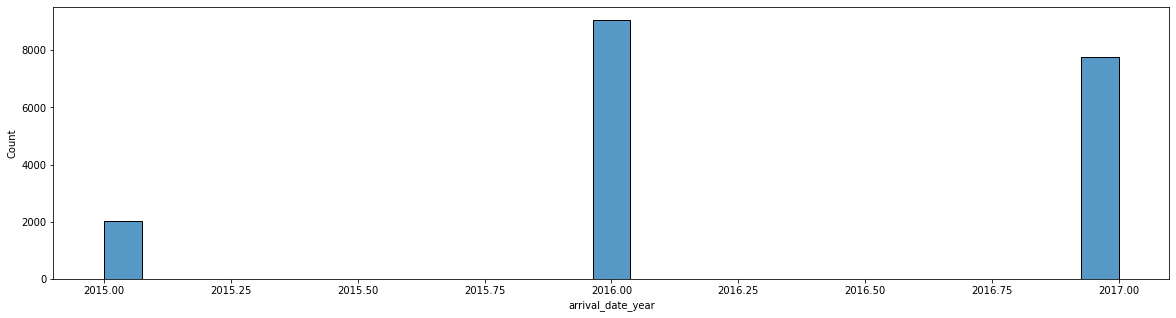

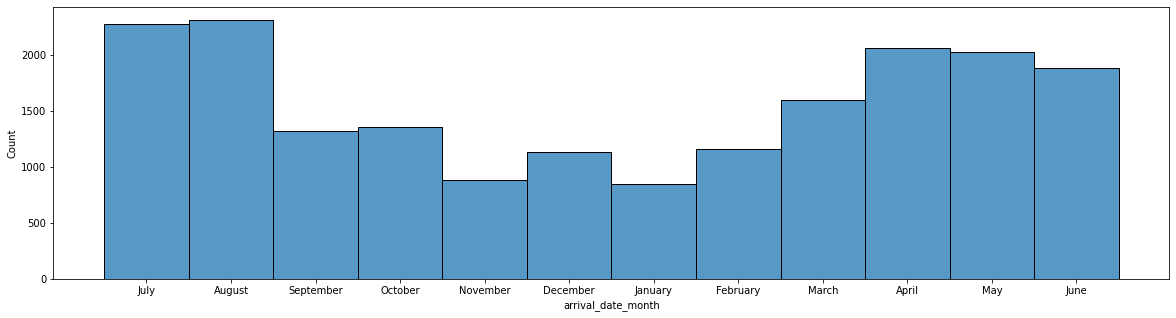

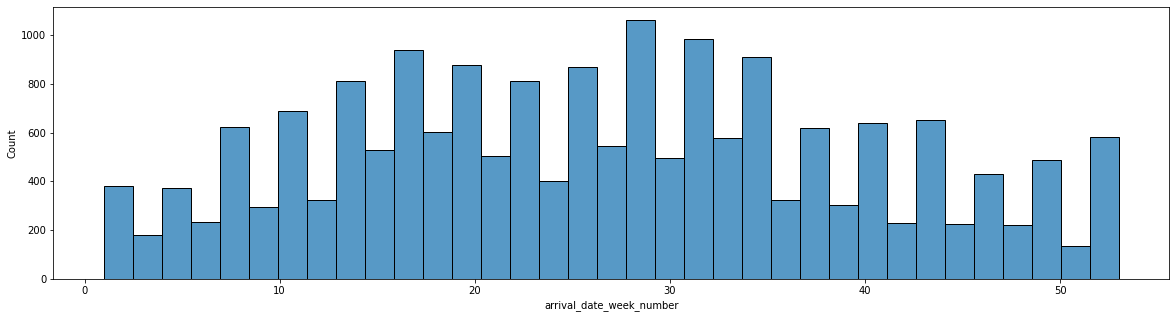

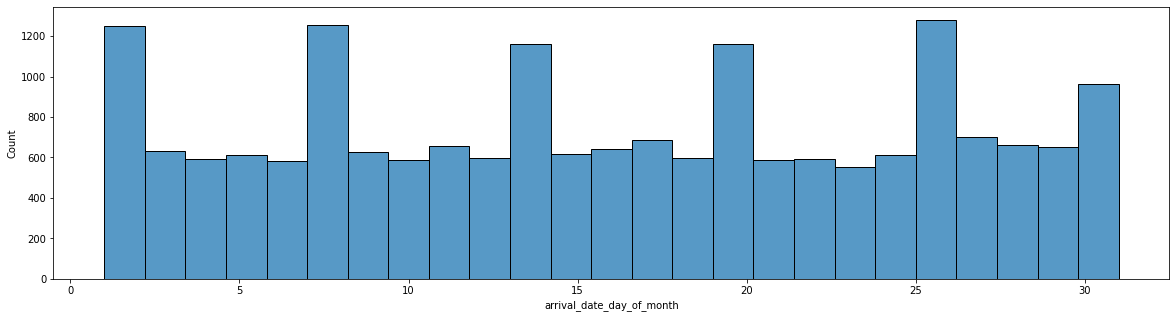

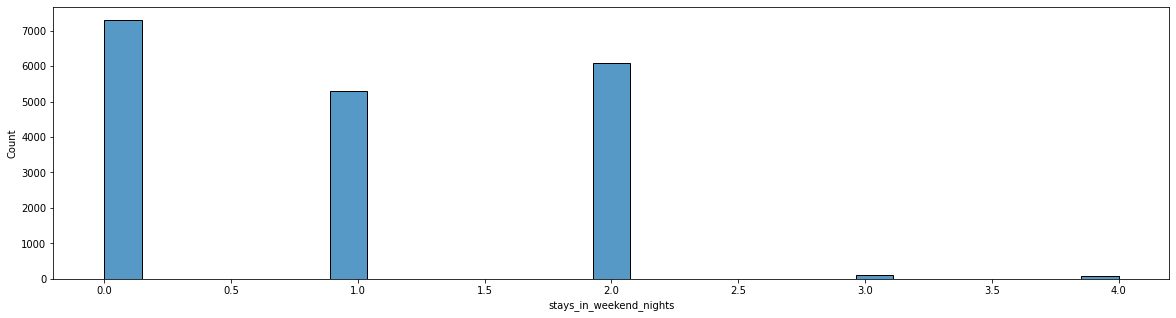

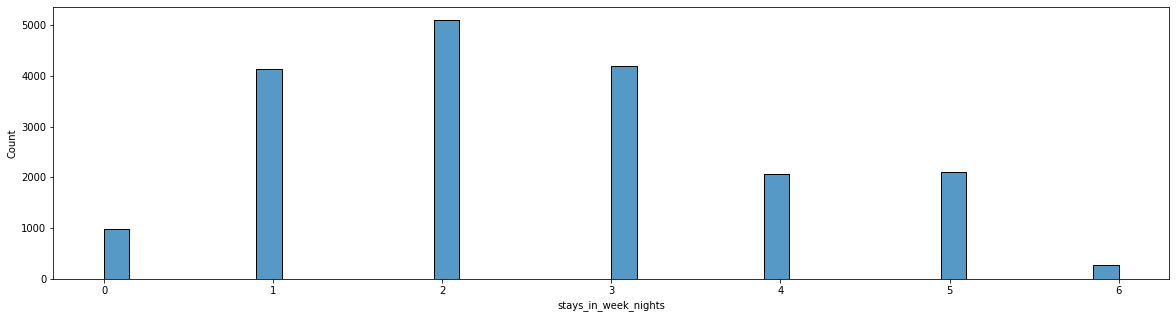

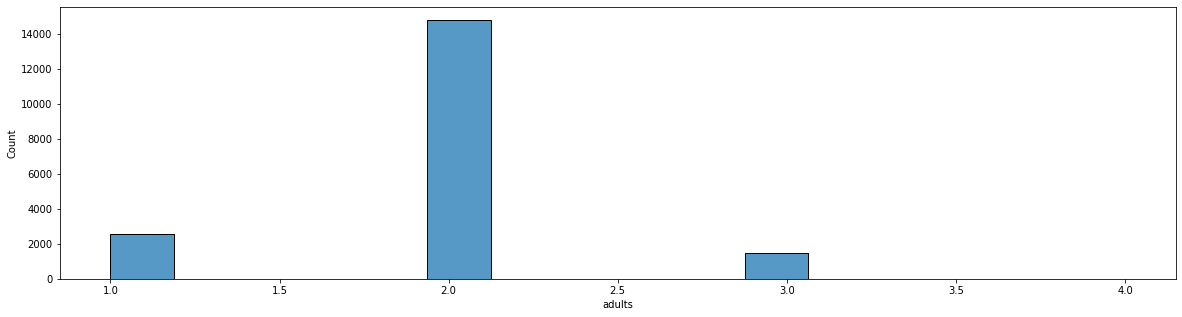

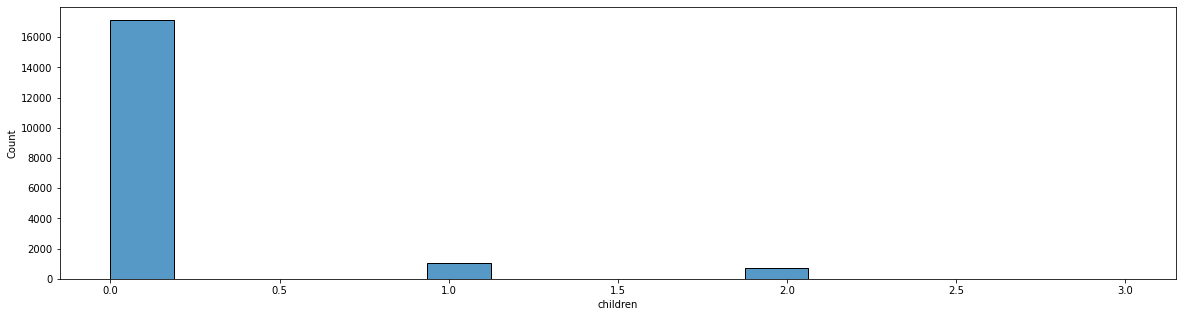

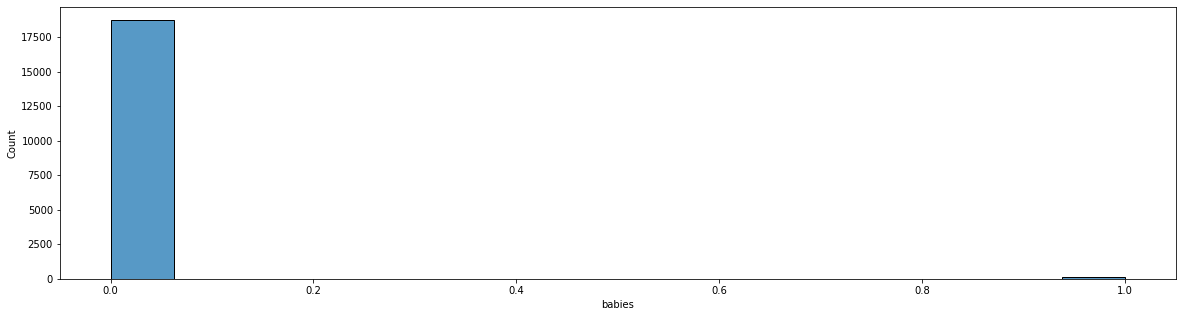

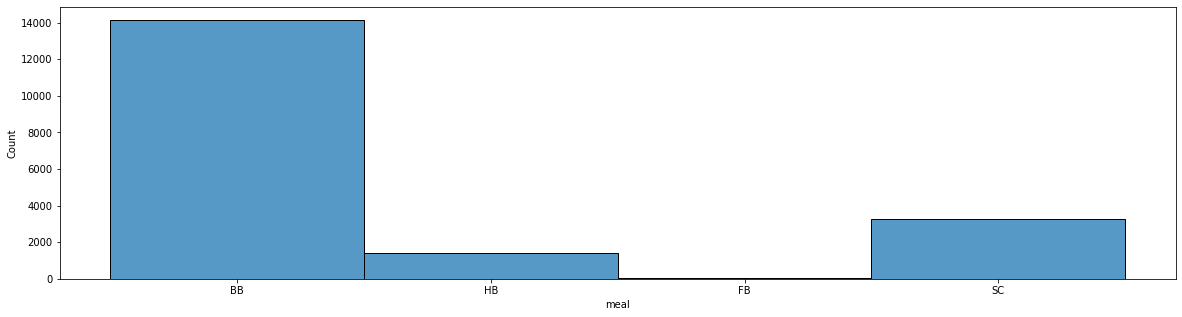

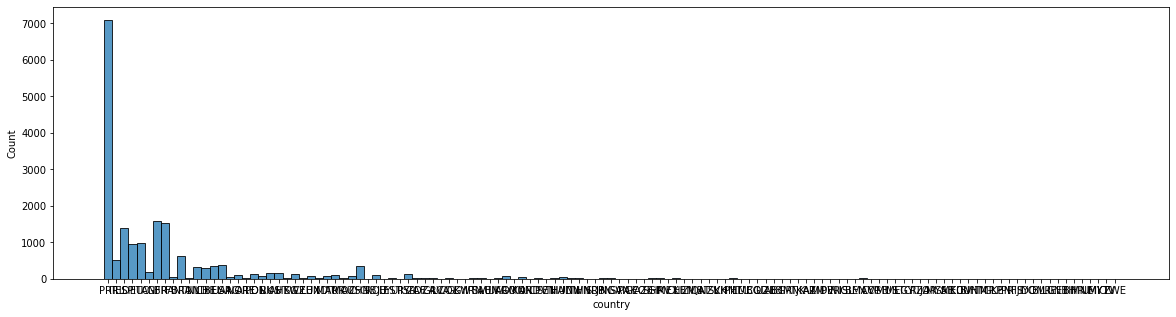

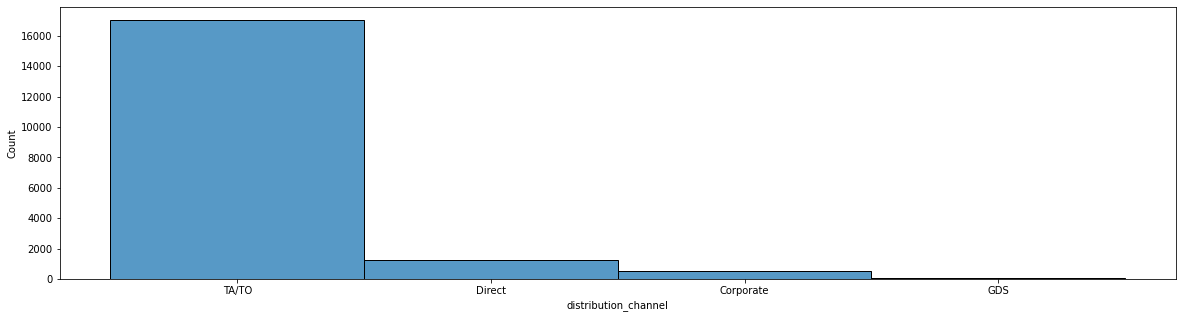

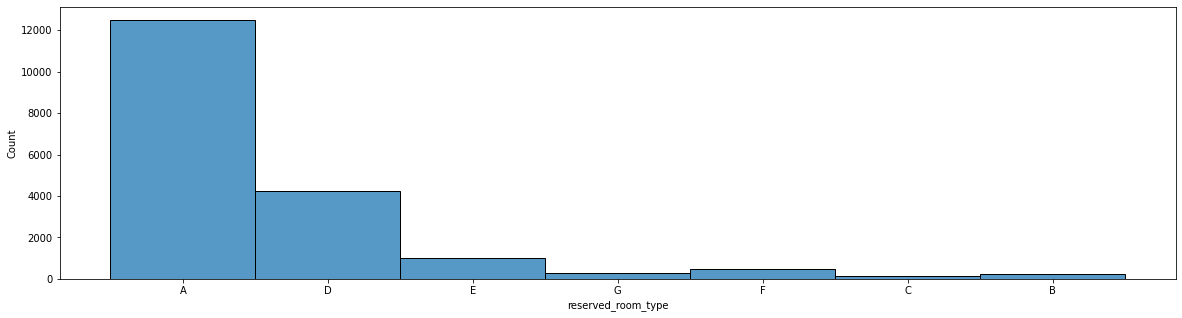

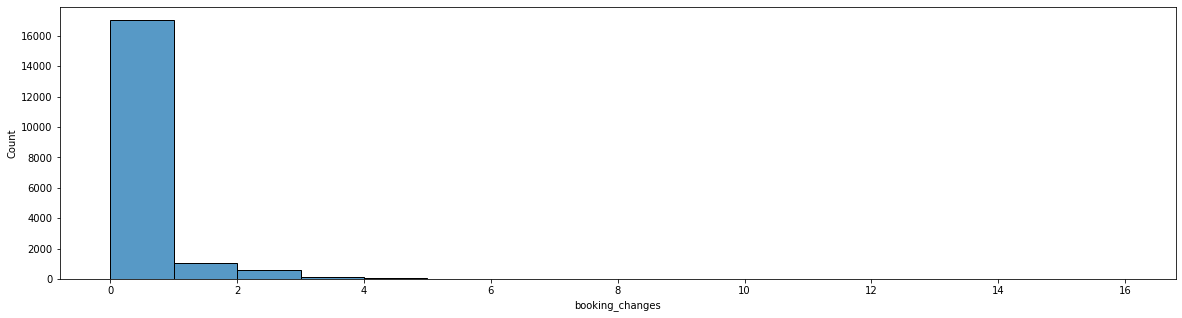

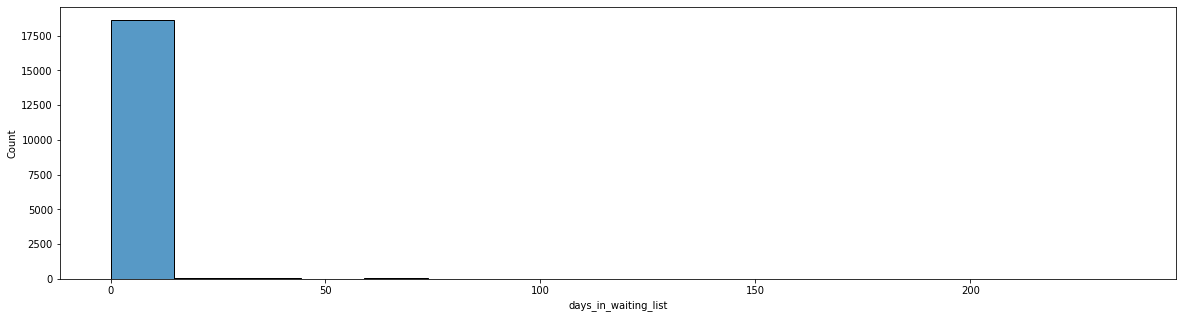

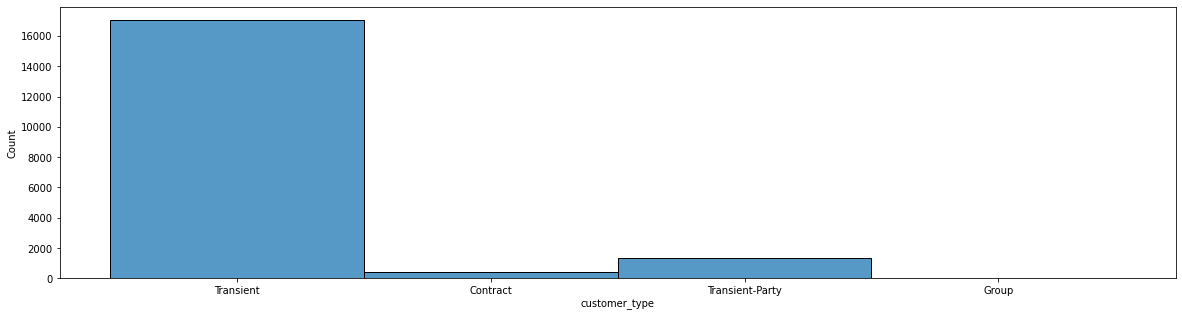

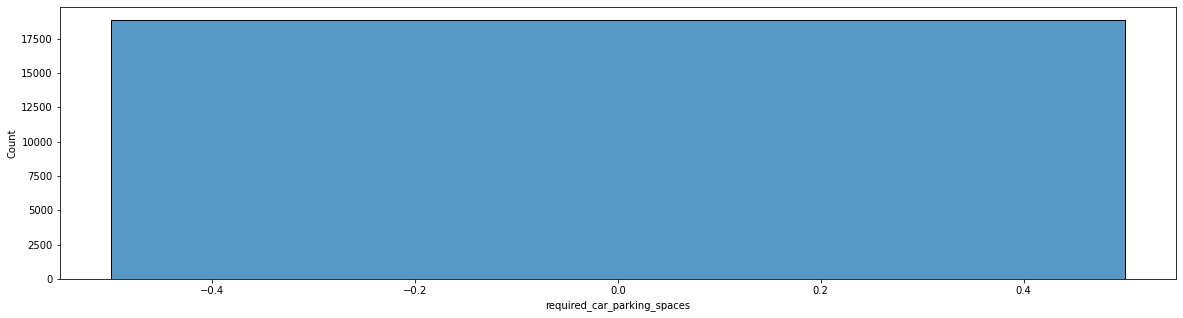

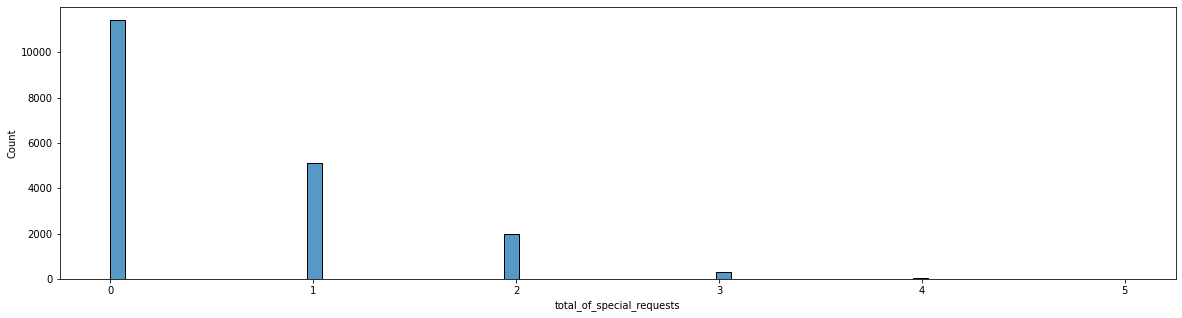

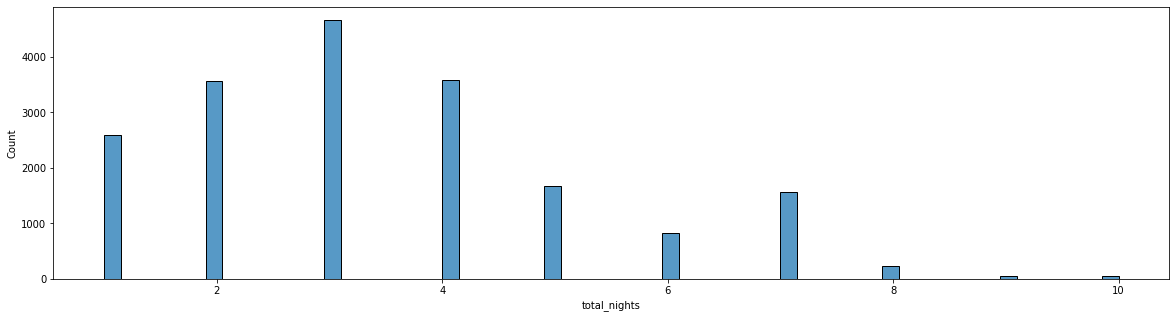

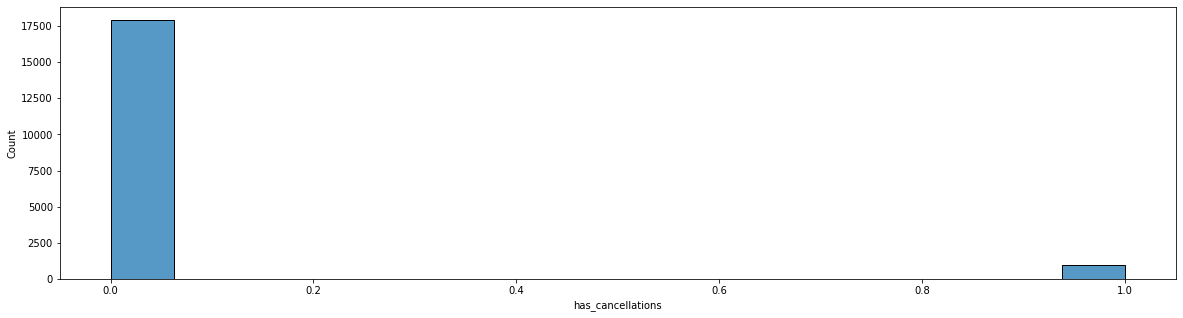

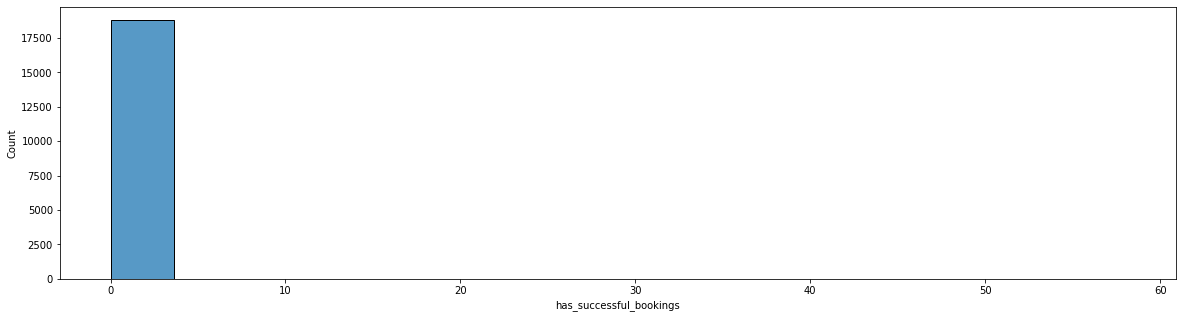

In [161]:
hist_my_data(df1, types=('int', 'float', 'object'))

В результате анализа было выявлено, что «ненадёжный» клиент обладает следующими харакатеристиками:
- количество дней между датой бронирования и датой прибытия равно 0;
- год заезда - 2016;
- месяц заезда - апрель;
- 18 неделя заезда;
- 17 число месяца;
- количество ночей - 2;
- снимает номер с еще одним взрослым постояльцем;
- без детей и младенцев;
- с включеным завтраком;
- из Португалии;
- канал дистрибуции заказа - через агенство;
- с бронью второй раз;
- без отмен ранее;
- без отмененных заказов ранее;
- с типом забронированной комнаты A;
- без зименений параметров закза;
- с моментальным потверждением заказа;
- тип заказчика не связан с договором или групповым заездом;
- без парковочного места;
- без специальных отметок в заказе.

### Общий вывод

**В результате проделанной работы можно отметить следующее:**
1) Используя модель случайного леса, обученного на сбалансированных данных методом уменьшения выборки, и введение депозитов позволило окупить бюджет, заложенный на разработку системы прогнозирования в течение тестового периода;

2) Был описан портрет «ненадёжного» клиента - удалось выявить характеритсики такого клиента, что в будущем позволит выявлять ситуации, когда гость может отменить бронь и заранее принять меры.